# Introduction

The telecommunication customer churn data contains information about a fictional telco company that provided home phone and Internet services to 7043 customers in California in Q3 2019. It indicates which customers have left, stayed, or signed up for their service. Multiple important demographics are included for each customer, as well as a Satisfaction Score, Churn Score, and Customer Lifetime Value (CLTV) index.

## Metadata

Each row represents a customer, each column contains customer’s attributes described on the column Metadata.

The data set includes information about:

* Customers who left within the last month – the column is called Churn
* Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies
* Customer account information – how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges
* Demographic info about customers – gender, age range, and if they have partners and dependents

# Import Libraries

In [1]:
!pip install skope-rules
!pip install eli5
!pip install scikit-plot
!pip install shap
!pip install lime
!pip install dalex
!pip install feature-engine

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 216 kB 8.3 MB/s 
     |████████████████████████████████| 133 kB 44.5 MB/s 
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107748 sha256=7a817ee36d991edf29afa4f27cd674b20152983c2a17bbfacd094d7a1c63ecfc
  Stored in directory: /root/.cache/pip/wheels/cc/3c/96/3ead31a8e6c20fc0f1a707fde2e05d49a80b1b4b30096573be
Successfully built eli5
  Attempting uninstall: jinja2
    Found existing installation: Jinja2 2.11.3
    Uninstalling Jinja2-2.11.3:
      Successfully uninstalled Jinja2-2.11.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flask 1.1.4 requires Jinja2<3.0,>=2.10.1, but you have jinja2 3.1.2 which 

In [2]:
import warnings
warnings.filterwarnings('ignore')

# import pandas for data wrangling
import pandas as pd
# import numpy for vectorize data manipulation
import numpy as np
# import matplotlib.pyplot, seaborn, and plotly.express module for data visualization
import matplotlib.pyplot as plt
palette = {0: 'tab:blue',1: 'tab:orange'}
import seaborn as sns
sns.set(style='whitegrid')
sns.set_palette("bright")
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import plotly.express as px

# import train and test split method from scikit-learn
from sklearn.model_selection import train_test_split
# import metrics method for model evaluation
import sklearn.metrics as metrics
# load logistic regression model
from sklearn.linear_model import LogisticRegression
# load k nearest neighbors model
from sklearn.neighbors import KNeighborsClassifier
# import random forest classifier
from sklearn.ensemble import RandomForestClassifier
# load tree visualization
from sklearn.tree import plot_tree, export_text
# load metrics
from sklearn.metrics import *
# load grid search
from sklearn.model_selection import GridSearchCV
# import SVM
from sklearn.svm import SVC
# import xgboost classifier
from xgboost import XGBClassifier
# import decision tree
from sklearn.tree import DecisionTreeClassifier
# load preprocessing module
from sklearn.preprocessing import *
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate, StratifiedKFold, RandomizedSearchCV, cross_val_score
from sklearn import svm,tree
from sklearn import ensemble
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay, precision_recall_curve, PrecisionRecallDisplay
from sklearn.model_selection import train_test_split as tts
from sklearn import model_selection

# load rulefit model
import six
import sys
sys.modules['sklearn.externals.six'] = six
from skrules import SkopeRules

# load scikit-plot modules
import scikitplot as skplt

# load shap package for shap explanation
import shap

# load eli5
import eli5

# load LimeTabularExplainer for LIME method
from lime.lime_tabular import LimeTabularExplainer 

# import dalex to explain complex model
import dalex as dx

# for Q-Q plots
import scipy.stats as stats
from feature_engine.outliers import Winsorizer
from scipy.stats import chi2_contingency

import os, random
import tensorflow as tf
from tensorflow import keras

#======Function========
def correlation_ratio(categories, measurements):
    fcat, _ = pd.factorize(categories)
    cat_num = np.max(fcat)+1
    y_avg_array = np.zeros(cat_num)
    n_array = np.zeros(cat_num)
    for i in range(0,cat_num):
        cat_measures = measurements[np.argwhere(fcat == i).flatten()]
        n_array[i] = len(cat_measures)
        y_avg_array[i] = np.average(cat_measures)
    y_total_avg = np.sum(np.multiply(y_avg_array,n_array))/np.sum(n_array)
    numerator = np.sum(np.multiply(n_array,np.power(np.subtract(y_avg_array,y_total_avg),2)))
    denominator = np.sum(np.power(np.subtract(measurements,y_total_avg),2))
    if numerator == 0:
        eta = 0.0
    else:
        eta = np.sqrt(numerator/denominator)
    return eta

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))


def create_stacked_bar_percent(data,column_name):
        
    # Get the percentage of default by each group
    default_by_group = pd.crosstab(index=data['attrition_flag'],columns = data[column_name], normalize = 'columns')
    default_by_group = default_by_group[default_by_group.iloc[1].sort_values().index]
    
    # Round up to 2 decimal
    default_by_group = default_by_group.apply(lambda x: round(x,2))
    
    labels = default_by_group.columns
    list1 = default_by_group.iloc[0].to_list()
    list2 = default_by_group.iloc[1].to_list()
    
    list1_name = "Not Churn"
    list2_name = "Churn"
    title = f" %Churn by {column_name}"
    xlabel = column_name
    ylabel = "Number of Churn"
    
    fig, ax = plt.subplots(figsize=(8,8),dpi=100)
    bar_width = 0.5
    
    ax1 = ax.bar(labels,list1, bar_width, label = list1_name)
    ax2 = ax.bar(labels,list2, bar_width, bottom = list1, label = list2_name)

    ax.set_title(title, fontweight = "bold",fontsize=12)
    ax.set_xlabel(xlabel, fontweight = "bold",fontsize=12)
    ax.set_ylabel(ylabel, fontweight = "bold",fontsize=12)
    ax.legend(loc="upper right")
    
    plt.xticks(list(range(len(labels))), labels,rotation=90)
    plt.yticks(fontsize=12)

    for r1, r2 in zip(ax1, ax2):
        h1 = r1.get_height()
        h2 = r2.get_height()
        plt.text(r1.get_x() + r1.get_width() / 2., h1 / 2., f"{h1:.0%}", ha="center", va="center", color="black", fontsize=12, fontweight="bold")
        plt.text(r2.get_x() + r2.get_width() / 2., h1 + h2 / 2., f"{h2:.0%}", ha="center", va="center", color="black", fontsize=12, fontweight="bold")

    plt.show()

def diagnostic_plots(data, variable):
    # function takes a dataframe (data) and
    # the variable of interest as arguments

    # define figure size
    plt.figure(figsize=(16, 4))

    # histogram
    plt.subplot(1, 3, 1)
    sns.histplot(data[variable], bins=30)
    plt.title('Histogram')

    # Q-Q plot
    plt.subplot(1, 3, 2)
    stats.probplot(data[variable], dist="norm", plot=plt)
    plt.ylabel('RM quantiles')

    # boxplot
    plt.subplot(1, 3, 3)
    sns.boxplot(y=data[variable])
    plt.title('Boxplot')

    plt.show()

def missing_check(data):
  missing = data.isnull().sum()
  missing_per = round(missing/len(data),4)*100
  unique_val = data.nunique()
  type_data = data.dtypes
  data = pd.DataFrame({'Missing_values':missing,
                    'Percent of Missing (%)':missing_per,
                    'Numbers of Unique':unique_val,
                    'Data type':type_data})
  return data

# Data Inspection

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dataset/WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [5]:
data

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [7]:
columns_name =[]
unique_value=[]
# Iterate through the columns
for col in data:
    if data[col].dtype == 'object':
        # If 2 or fewer unique categories
        columns_name.append(str(col)) 
        unique_value.append(data[col].nunique())
table= pd.DataFrame()
table['Columns'] = columns_name
table['Unique']= unique_value
            
table=table.sort_values('Unique',ascending=False)
table

,Columns,Unique
0,customerID,7043
16,TotalCharges,6531
15,PaymentMethod,4
8,OnlineBackup,3
13,Contract,3
12,StreamingMovies,3
11,StreamingTV,3
10,TechSupport,3
9,DeviceProtection,3
7,OnlineSecurity,3


In [8]:
# extracting categorical columns
cat = data.select_dtypes(include = ['object'])

# printing unique values of each column
for col in cat.columns:
    print(f"{col}: \n{cat[col].unique()}\n")

customerID: 
['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']

gender: 
['Female' 'Male']

Partner: 
['Yes' 'No']

Dependents: 
['No' 'Yes']

PhoneService: 
['No' 'Yes']

MultipleLines: 
['No phone service' 'No' 'Yes']

InternetService: 
['DSL' 'Fiber optic' 'No']

OnlineSecurity: 
['No' 'Yes' 'No internet service']

OnlineBackup: 
['Yes' 'No' 'No internet service']

DeviceProtection: 
['No' 'Yes' 'No internet service']

TechSupport: 
['No' 'Yes' 'No internet service']

StreamingTV: 
['No' 'Yes' 'No internet service']

StreamingMovies: 
['No' 'Yes' 'No internet service']

Contract: 
['Month-to-month' 'One year' 'Two year']

PaperlessBilling: 
['Yes' 'No']

PaymentMethod: 
['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']

TotalCharges: 
['29.85' '1889.5' '108.15' ... '346.45' '306.6' '6844.5']

Churn: 
['No' 'Yes']



# Data Preparation

### Missing Values Handling

In [9]:
data.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [10]:
#handling missing value
data['TotalCharges']=data['TotalCharges'].replace(' ',np.nan)

In [11]:
#cek missing value
data.isnull().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [12]:
#handling missing value
data['TotalCharges'].fillna(data['TotalCharges'].median(),inplace=True)

In [13]:
#change data type
data['TotalCharges']=data['TotalCharges'].astype('float')

In [14]:
#cek missing value
data.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [15]:
# Data Profilling
print("="*10,"Data Profilling","="*10)

# Data Shape
print("Data shape :", data.shape)
print("")

# Data Info
print("Data info :")
print(data.info())
print("")

# Data duplication
print("Data duplication :")
print(data.duplicated().sum())
print("")

========== Data Profilling ==========
Data shape : (7043, 21)

Data info :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract      

### Data Transformation

In [16]:
# Change Definition
data['SeniorCitizen'] = data['SeniorCitizen'].replace({0:'No', 1:'Yes'})
data['PaymentMethod'] = data['PaymentMethod'].replace({'Electronic check':'Check', 'Mailed check':'Check', 'Bank transfer (automatic)':'Bank/Credit Card','Credit card (automatic)':'Bank/Credit Card'})

In [17]:
#handling inconsistency
data["MultipleLines"] = data["MultipleLines"].replace("No phone service","No")
data["OnlineSecurity"] = data["OnlineSecurity"].replace("No internet service","No")
data["DeviceProtection"] = data["DeviceProtection"].replace("No internet service","No")
data["OnlineBackup"] = data["OnlineBackup"].replace("No internet service","No")
data["TechSupport"] = data["TechSupport"].replace("No internet service","No")
data["StreamingTV"] = data["StreamingTV"].replace("No internet service","No")
data["StreamingMovies"] = data["StreamingMovies"].replace("No internet service","No")

## Droping The Unused Data

In [18]:
data = data.drop(['customerID'], axis=1)

In [19]:
data

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,No,Yes,No,1,No,No,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Check,29.85,29.85,No
1,Male,No,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Check,56.95,1889.50,No
2,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Check,53.85,108.15,Yes
3,Male,No,No,No,45,No,No,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank/Credit Card,42.30,1840.75,No
4,Female,No,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,Male,No,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Check,84.80,1990.50,No
7039,Female,No,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Bank/Credit Card,103.20,7362.90,No
7040,Female,No,Yes,Yes,11,No,No,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Check,29.60,346.45,No
7041,Male,Yes,Yes,No,4,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Check,74.40,306.60,Yes


In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   object 
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


In [21]:
# extracting categorical columns
cat = data.select_dtypes(include = ['object'])

# printing unique values of each column
for col in cat.columns:
    print(f"{col}: \n{cat[col].unique()}\n")

gender: 
['Female' 'Male']

SeniorCitizen: 
['No' 'Yes']

Partner: 
['Yes' 'No']

Dependents: 
['No' 'Yes']

PhoneService: 
['No' 'Yes']

MultipleLines: 
['No' 'Yes']

InternetService: 
['DSL' 'Fiber optic' 'No']

OnlineSecurity: 
['No' 'Yes']

OnlineBackup: 
['Yes' 'No']

DeviceProtection: 
['No' 'Yes']

TechSupport: 
['No' 'Yes']

StreamingTV: 
['No' 'Yes']

StreamingMovies: 
['No' 'Yes']

Contract: 
['Month-to-month' 'One year' 'Two year']

PaperlessBilling: 
['Yes' 'No']

PaymentMethod: 
['Check' 'Bank/Credit Card']

Churn: 
['No' 'Yes']



##  Data Correlation

In [22]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
tenure,7043.0,32.371149,24.559481,0.00,9.000,29.000,55.00,72.00
MonthlyCharges,7043.0,64.761692,30.090047,18.25,35.500,70.350,89.85,118.75
TotalCharges,7043.0,2281.916928,2265.270398,18.80,402.225,1397.475,3786.60,8684.80


### Correlation between Quantitative Variables

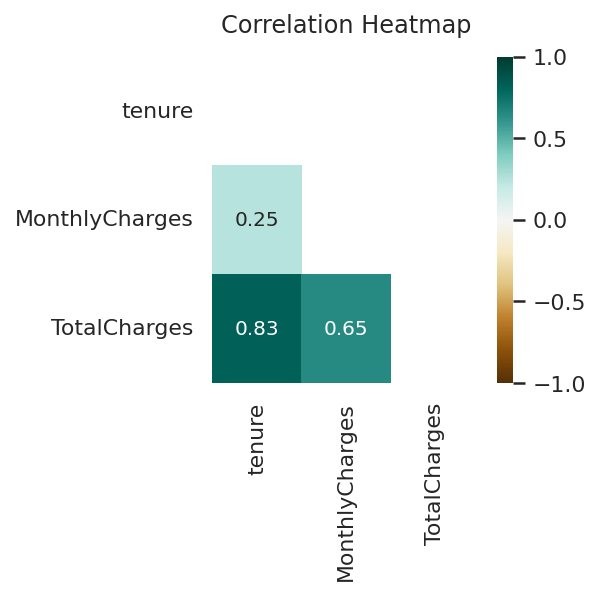

In [23]:
# Increase the size of the heatmap
plt.figure(figsize=(3,3))

# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap
mask = np.triu(np.ones_like(data.corr(), dtype=np.bool))
heatmap = sns.heatmap(data.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')

# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

### Correlation between Qualitative Variables

In [24]:
def cramers_corrected_stat(contingency_table):
    """
        Computes corrected Cramer's V statistic for categorial-categorial association
    """
    
    try:
        chi2 = chi2_contingency(contingency_table)[0]
    except ValueError:
        return np.NaN
    
    n = contingency_table.sum().sum()
    phi2 = chi2/n
    
    r, k = contingency_table.shape
    r_corrected = r - (((r-1)**2)/(n-1))
    k_corrected = k - (((k-1)**2)/(n-1))
    phi2_corrected = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    
    return (phi2_corrected / min( (k_corrected-1), (r_corrected-1)))**0.5

In [25]:
def categorical_corr_matrix(data):
    """
        Computes corrected Cramer's V statistic between all the
        categorical variables in the dataframe
    """
    data = data.select_dtypes(include='object')
    cols = data.columns
    n = len(cols)
    corr_matrix = pd.DataFrame(np.zeros(shape=(n, n)), index=cols, columns=cols)
    
    excluded_cols = list()
    
    for col1 in cols:
        for col2 in cols:
            if col1 == col2:
                corr_matrix.loc[col1, col2] = 1
                break
            data_crosstab = pd.crosstab(data[col1], data[col2], dropna=False)
            corr_matrix.loc[col1, col2] = cramers_corrected_stat(data_crosstab)
                
    # Flip and add to get full correlation matrix
    corr_matrix += np.tril(corr_matrix, k=-1).T
    return corr_matrix

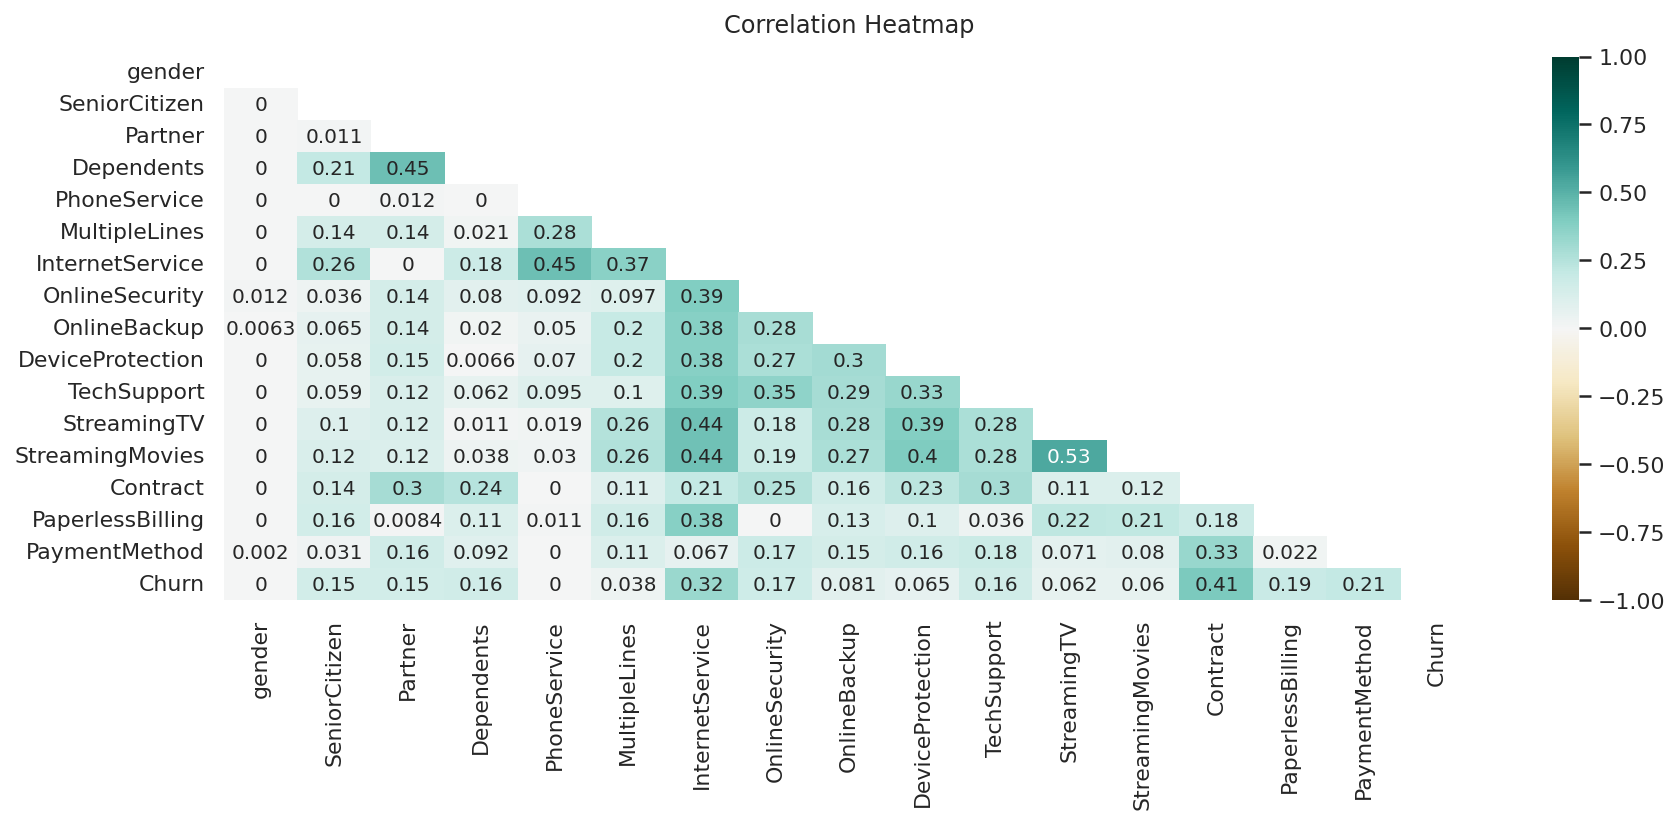

In [26]:
# Increase the size of the heatmap
plt.figure(figsize=(14,5))

# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap
mask = np.triu(np.ones_like(categorical_corr_matrix(data), dtype=np.bool))
heatmap = sns.heatmap(categorical_corr_matrix(data), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')

# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

# Exploratory Data Analysis

## Frequency Distribution: Categorical Variables

In [27]:
churn = data['Churn'].value_counts()

fig = px.pie(churn, 
             values = churn.values, 
             names = churn.index)
fig.update_traces(textposition='inside', textinfo='percent+label+value', 
                  marker = dict(line = dict(color = 'white', width = 2)))
fig.show(figsize=(3,3))

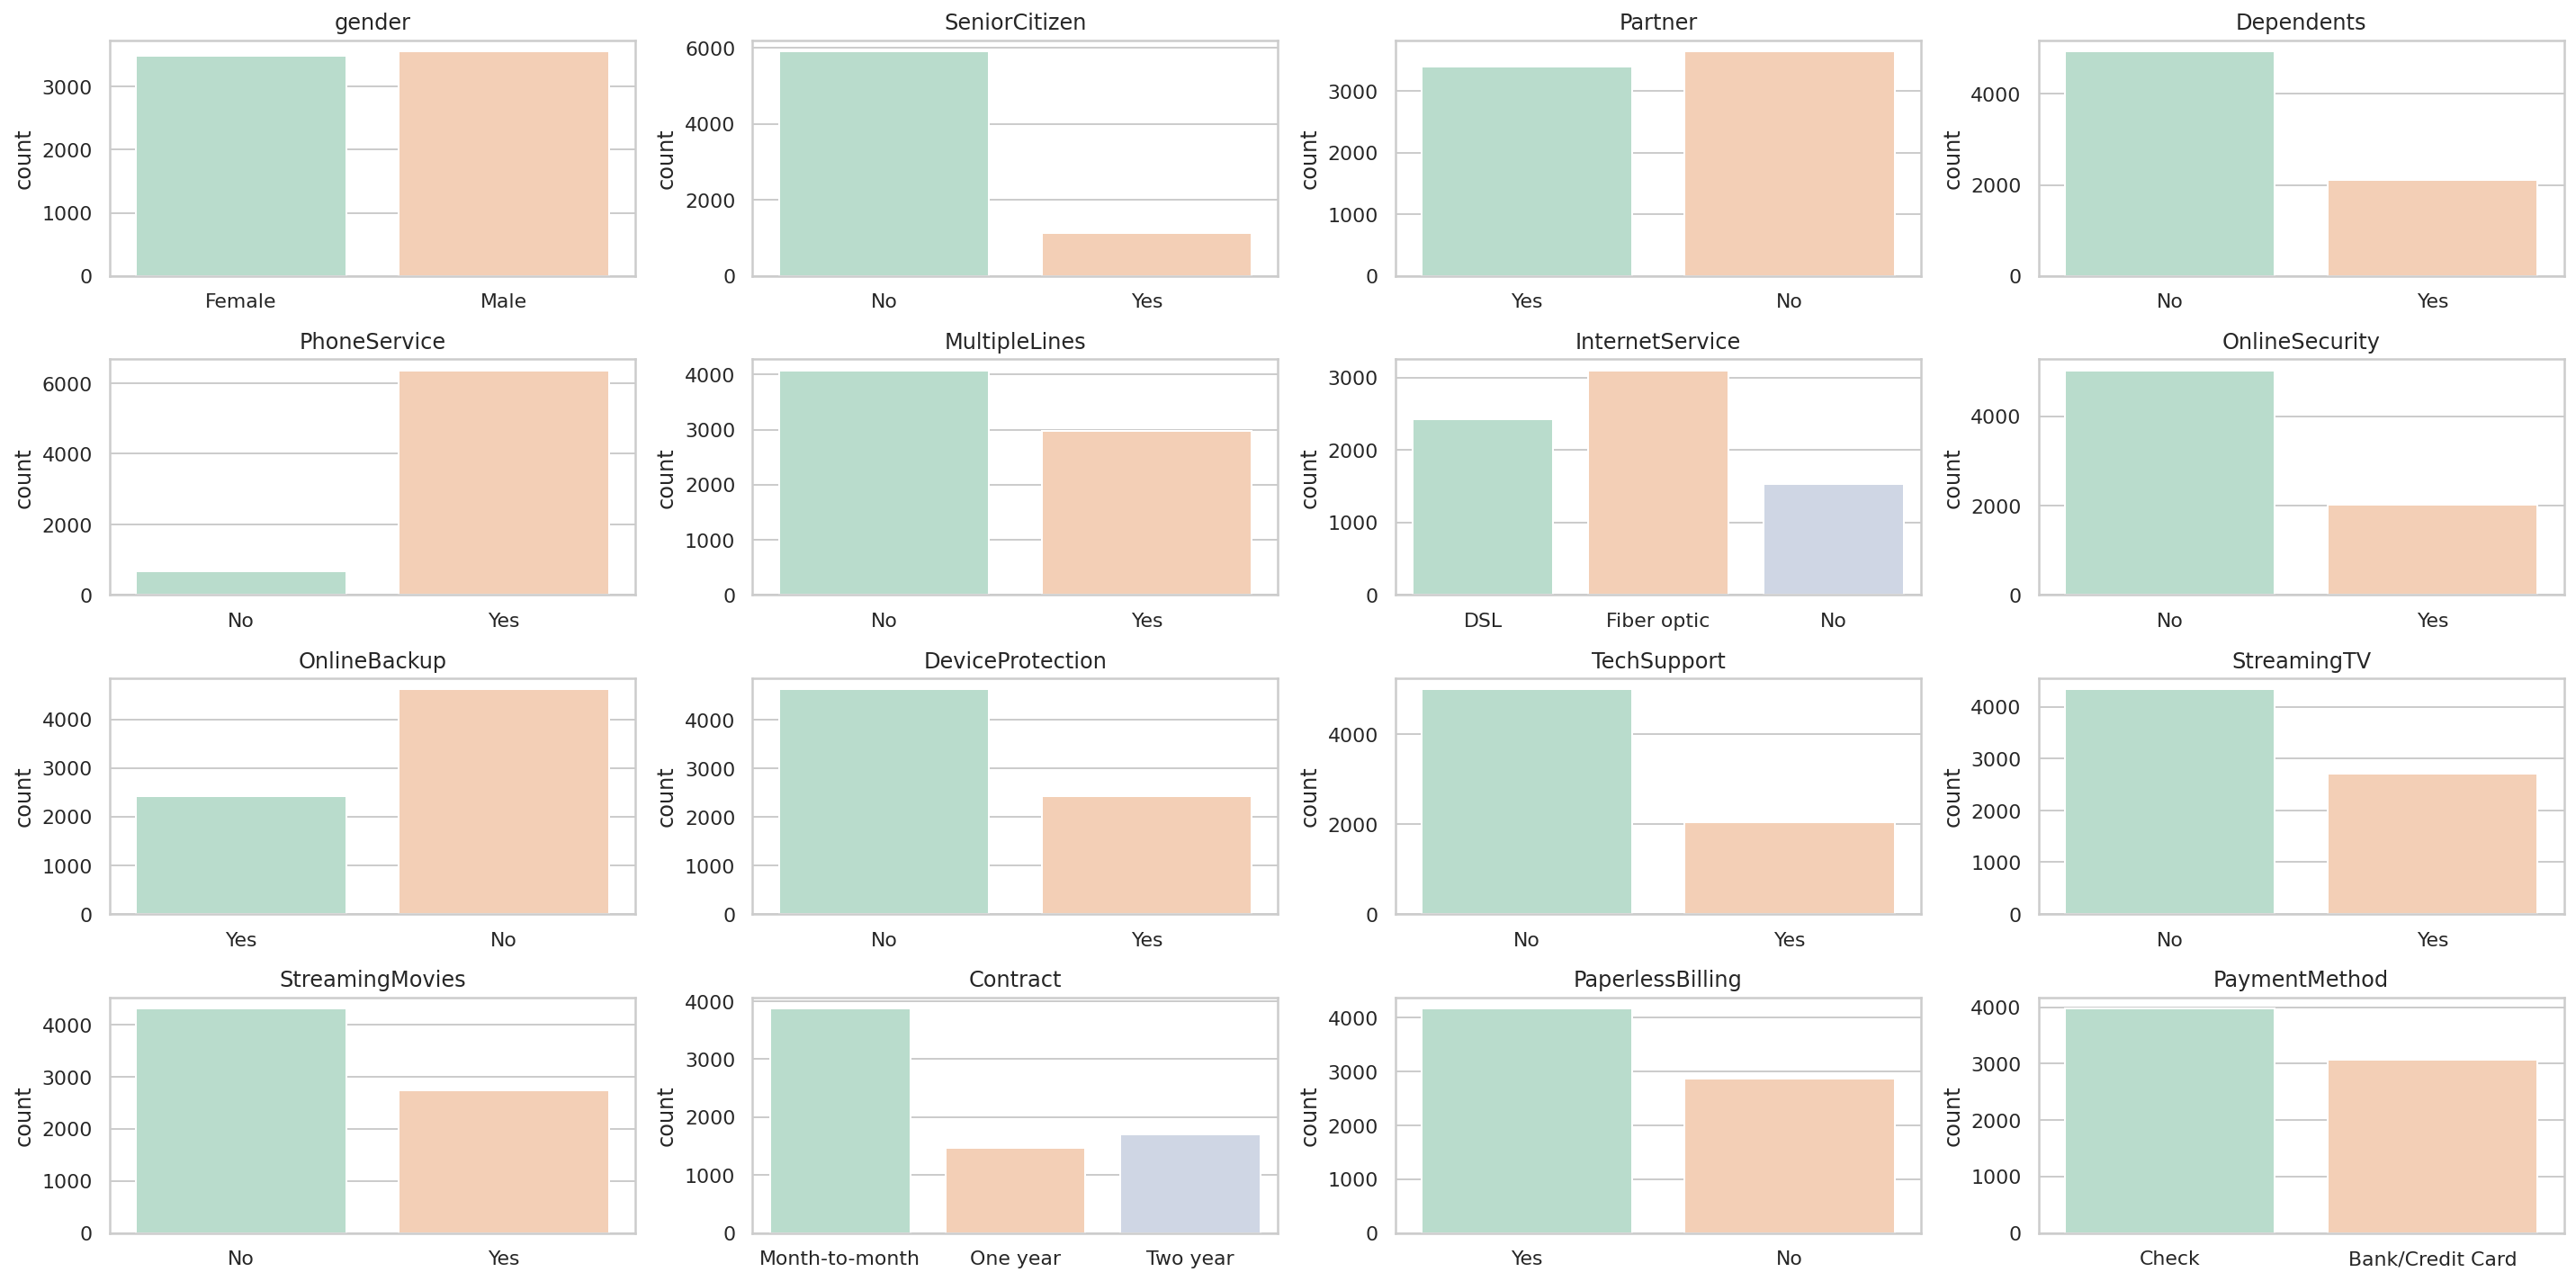

In [28]:
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(20, 10))
titles = list(data.select_dtypes(include=['object']))

ax_title_pairs = zip(axs.flat, titles)

for ax, title in ax_title_pairs:
    sns.countplot(x=title, data=data, palette='Pastel2', ax=ax)
    ax.set_title(title)
    ax.set_xlabel('')

plt.tight_layout()

## Frequency Distribution: Categorical Variables by Churn

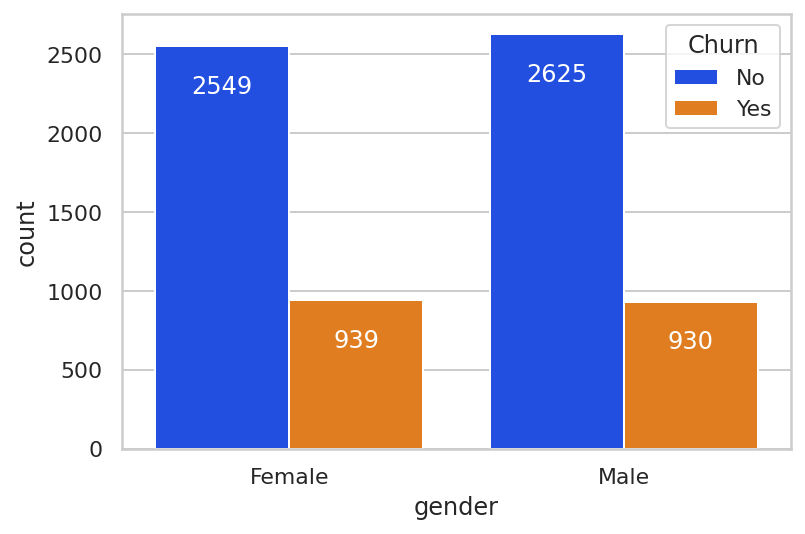

In [29]:
ax = sns.countplot(x="gender", hue="Churn", data=data)
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()), ha='center', va='top', color='white', size=12)

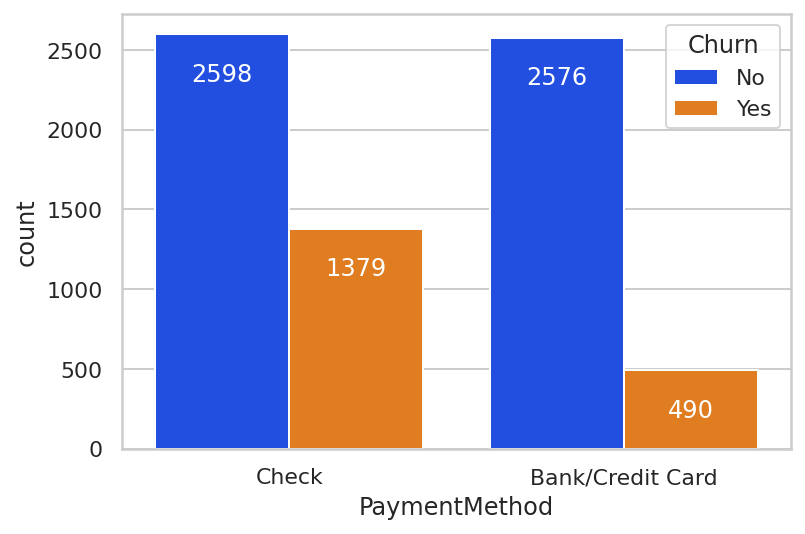

In [30]:
ax = sns.countplot(x="PaymentMethod", hue="Churn", data=data)
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()), ha='center', va='top', color='white', size=12)

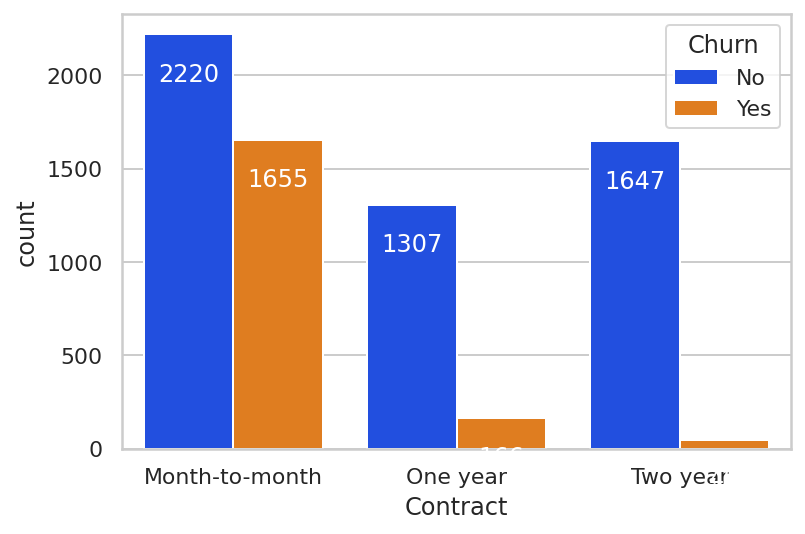

In [31]:
ax = sns.countplot(x="Contract", hue="Churn", data=data)
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()), ha='center', va='top', color='white', size=12)

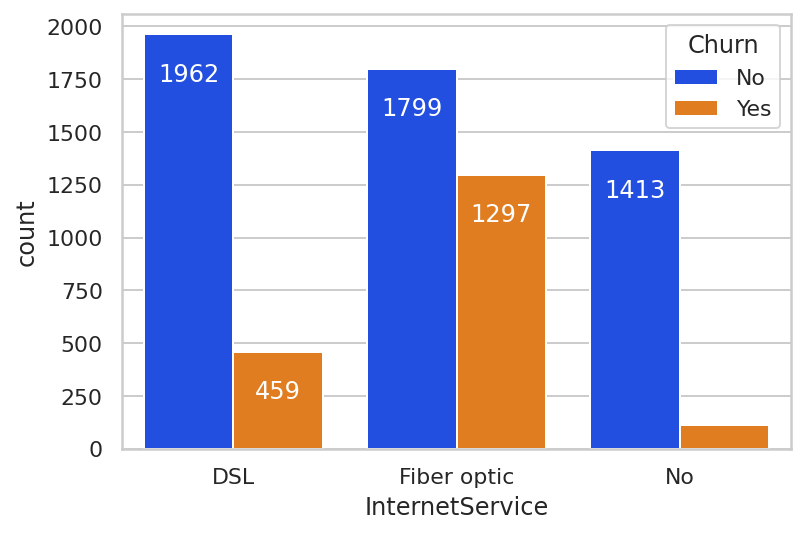

In [32]:
ax = sns.countplot(x="InternetService", hue="Churn", data=data)
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()), ha='center', va='top', color='white', size=12)

## Frequency Distribution: Continuous Variables

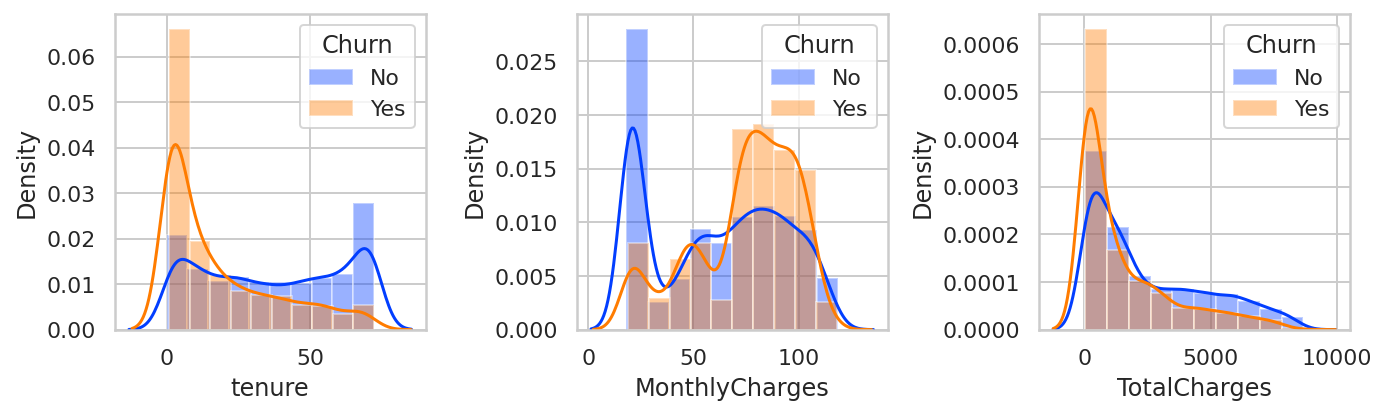

In [33]:
data_grouped = data.groupby(by='Churn')
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(16,3))
titles = list(data.select_dtypes(exclude=['object']))

ax_title_pairs = zip(axs.flat, titles)

for ax, title in ax_title_pairs:
    sns.distplot(data_grouped.get_group('No')[title], bins=10, ax=ax,label='No')
    sns.distplot(data_grouped.get_group('Yes')[title], bins=10, ax=ax,label='Yes')
    ax.legend(title='Churn')

axs.flat[-1].remove()
axs.flat[-2].remove()
fig.tight_layout()

## Box Plots : Outlier Detection

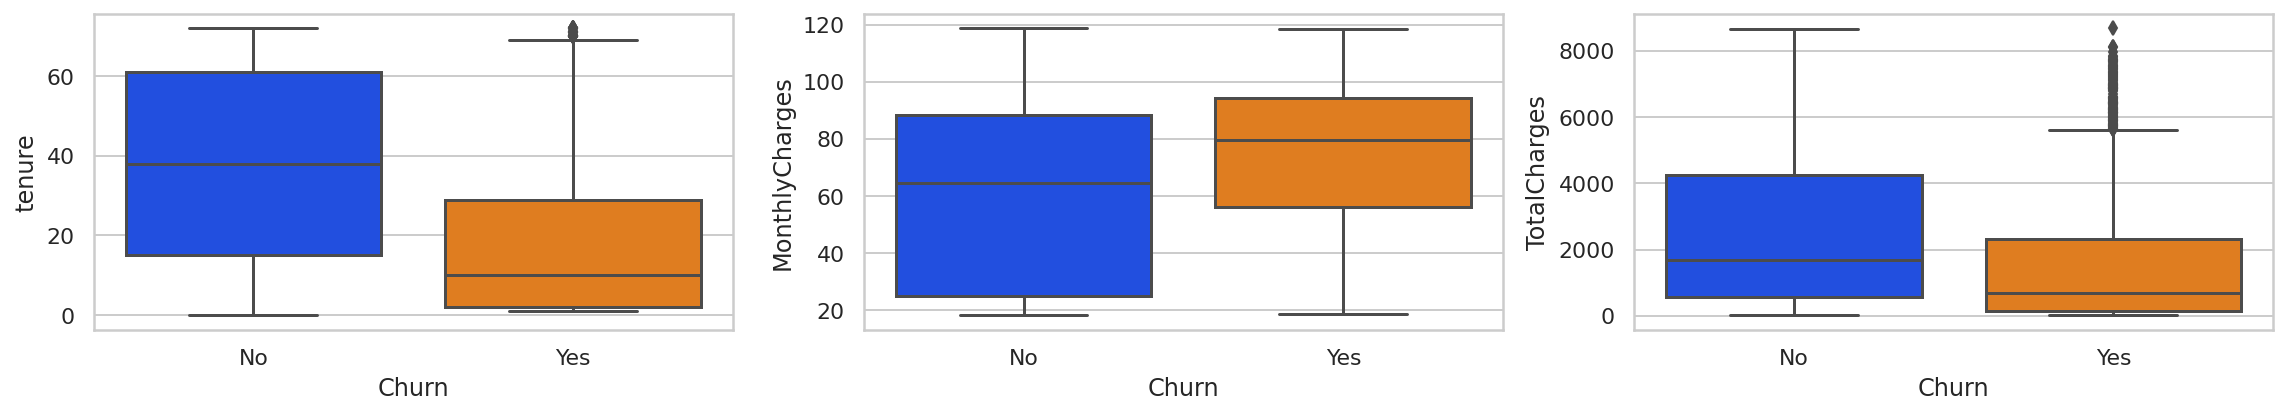

In [34]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16,3))
titles = data.select_dtypes(exclude=['object'])

ax_title_pairs = zip(axs.flat, titles)

for ax, title in ax_title_pairs:
    sns.boxplot(x='Churn', y=title, data=data, ax=ax)
fig.tight_layout()

In [35]:
# Removing Outliers on train data
titles = data.select_dtypes(exclude=['object'])
for col in titles:
  Q1 = data[col].quantile(0.25)
  Q3 = data[col].quantile(0.75)
  IQR = Q3 - Q1
  Lwishker = Q1 - 1.5 * IQR
  Uwishker = Q3 + 1.5 * IQR
  data[col] = data[col].clip(Lwishker, Uwishker)

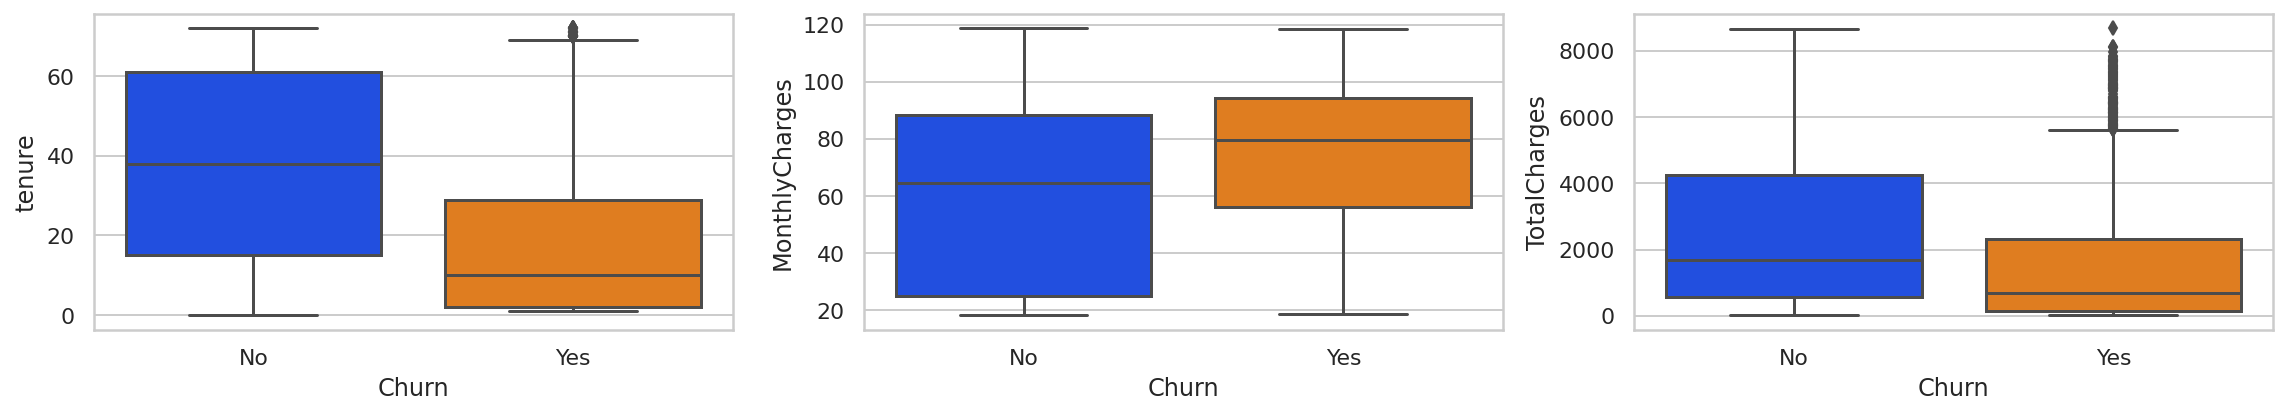

In [36]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16,3))
titles = data.select_dtypes(exclude=['object'])

ax_title_pairs = zip(axs.flat, titles)

for ax, title in ax_title_pairs:
    sns.boxplot(x='Churn', y=title, data=data, ax=ax)
fig.tight_layout()

# Data Pre-Processing

## Data Encoding

In [37]:
data['SeniorCitizen'] = data['SeniorCitizen'].replace({'No':0, 'Yes':1})
data['Contract'] = data['Contract'].replace({'Month-to-month':0, 'One year':1, 'Two year':1})
data['PaymentMethod'] = data['PaymentMethod'].replace({'Check':0, 'Bank/Credit Card':1})
data['gender'] = data['gender'].replace({'Male':1, 'Female':0})
data['Partner'] = data['Partner'].replace({'No':0, 'Yes':1})
data['Dependents'] = data['Dependents'].replace({'No':0, 'Yes':1})
data['PhoneService'] = data['PhoneService'].replace({'No':0, 'Yes':1})
data['MultipleLines'] = data['MultipleLines'].replace({'No':0, 'Yes':1})
data['InternetService'] = data['InternetService'].replace({'No':0, 'DSL':1,'Fiber optic':1})
data['OnlineSecurity'] = data['OnlineSecurity'].replace({'No':0, 'Yes':1})
data['OnlineBackup'] = data['OnlineBackup'].replace({'No':0, 'Yes':1})
data['DeviceProtection'] = data['DeviceProtection'].replace({'No':0, 'Yes':1})
data['TechSupport'] = data['TechSupport'].replace({'No':0, 'Yes':1})
data['StreamingTV'] = data['StreamingTV'].replace({'No':0, 'Yes':1})
data['StreamingMovies'] = data['StreamingMovies'].replace({'No':0, 'Yes':1})
data['PaperlessBilling'] = data['PaperlessBilling'].replace({'No':0, 'Yes':1})
data['Churn'] = data['Churn'].replace({'No':0, 'Yes':1})

In [38]:
data

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,1,0,1,0,0,1,0,1,0,0,0,0,0,1,0,29.85,29.85,0
1,1,0,0,0,34,1,0,1,1,0,1,0,0,0,1,0,0,56.95,1889.50,0
2,1,0,0,0,2,1,0,1,1,1,0,0,0,0,0,1,0,53.85,108.15,1
3,1,0,0,0,45,0,0,1,1,0,1,1,0,0,1,0,1,42.30,1840.75,0
4,0,0,0,0,2,1,0,1,0,0,0,0,0,0,0,1,0,70.70,151.65,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,1,0,1,1,24,1,1,1,1,0,1,1,1,1,1,1,0,84.80,1990.50,0
7039,0,0,1,1,72,1,1,1,0,1,1,0,1,1,1,1,1,103.20,7362.90,0
7040,0,0,1,1,11,0,0,1,1,0,0,0,0,0,0,1,0,29.60,346.45,0
7041,1,1,1,0,4,1,1,1,0,0,0,0,0,0,0,1,0,74.40,306.60,1


## Resampling

In [39]:
# Assign 'TARGET' column to y 
y = data['Churn'].values
# Assign all columns except 'TARGET' to X
X = data.drop(['Churn'], axis = 1).values

In [40]:
# Check dimension
print('X shape :', X.shape)
print('y shape :', y.shape)

X shape : (7043, 19)
y shape : (7043,)


In [41]:
# split data to train and test data
# with test size is 20% of overall data
# use stratified sampling
# and set RNG to 1000
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = 0.2,
    stratify = y,
    random_state = 42
)

In [42]:
# Make a new dataframe using train & test data
train_data_x = pd.DataFrame(X_train, columns=data.drop(['Churn'], axis = 1).columns)
train_data_y = pd.DataFrame(y_train, columns=['Churn'])
train_data = pd.concat([train_data_x, train_data_y], axis=1)

test_data_x = pd.DataFrame(X_test, columns=data.drop(['Churn'], axis = 1).columns)
test_data_y = pd.DataFrame(y_test, columns=['Churn'])
test_data = pd.concat([test_data_x, test_data_y], axis=1)

In [43]:
train_data

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,1.0,0.0,0.0,0.0,35.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,49.20,1701.65,0
1,1.0,0.0,1.0,1.0,15.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,75.10,1151.55,0
2,1.0,0.0,1.0,1.0,13.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,40.55,590.35,0
3,0.0,0.0,1.0,0.0,26.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,73.50,1905.70,0
4,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,44.55,44.55,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5629,0.0,0.0,1.0,0.0,71.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,109.25,7707.70,0
5630,1.0,0.0,0.0,0.0,2.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,46.05,80.35,1
5631,0.0,1.0,0.0,0.0,25.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,102.80,2660.20,1
5632,0.0,0.0,1.0,0.0,24.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,20.40,482.80,0


In [44]:
test_data

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,1.0,0.0,1.0,1.0,72.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,114.05,8468.20,0
1,0.0,1.0,0.0,0.0,8.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,100.15,908.55,0
2,0.0,0.0,1.0,1.0,41.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,78.35,3211.20,0
3,1.0,0.0,1.0,0.0,18.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,78.20,1468.75,0
4,0.0,0.0,1.0,0.0,72.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,82.65,5919.35,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1404,0.0,0.0,1.0,1.0,49.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,87.20,4345.00,0
1405,1.0,0.0,1.0,1.0,28.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,20.30,487.95,0
1406,1.0,0.0,0.0,0.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,20.65,93.55,0
1407,0.0,0.0,0.0,0.0,56.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,19.70,1051.90,0


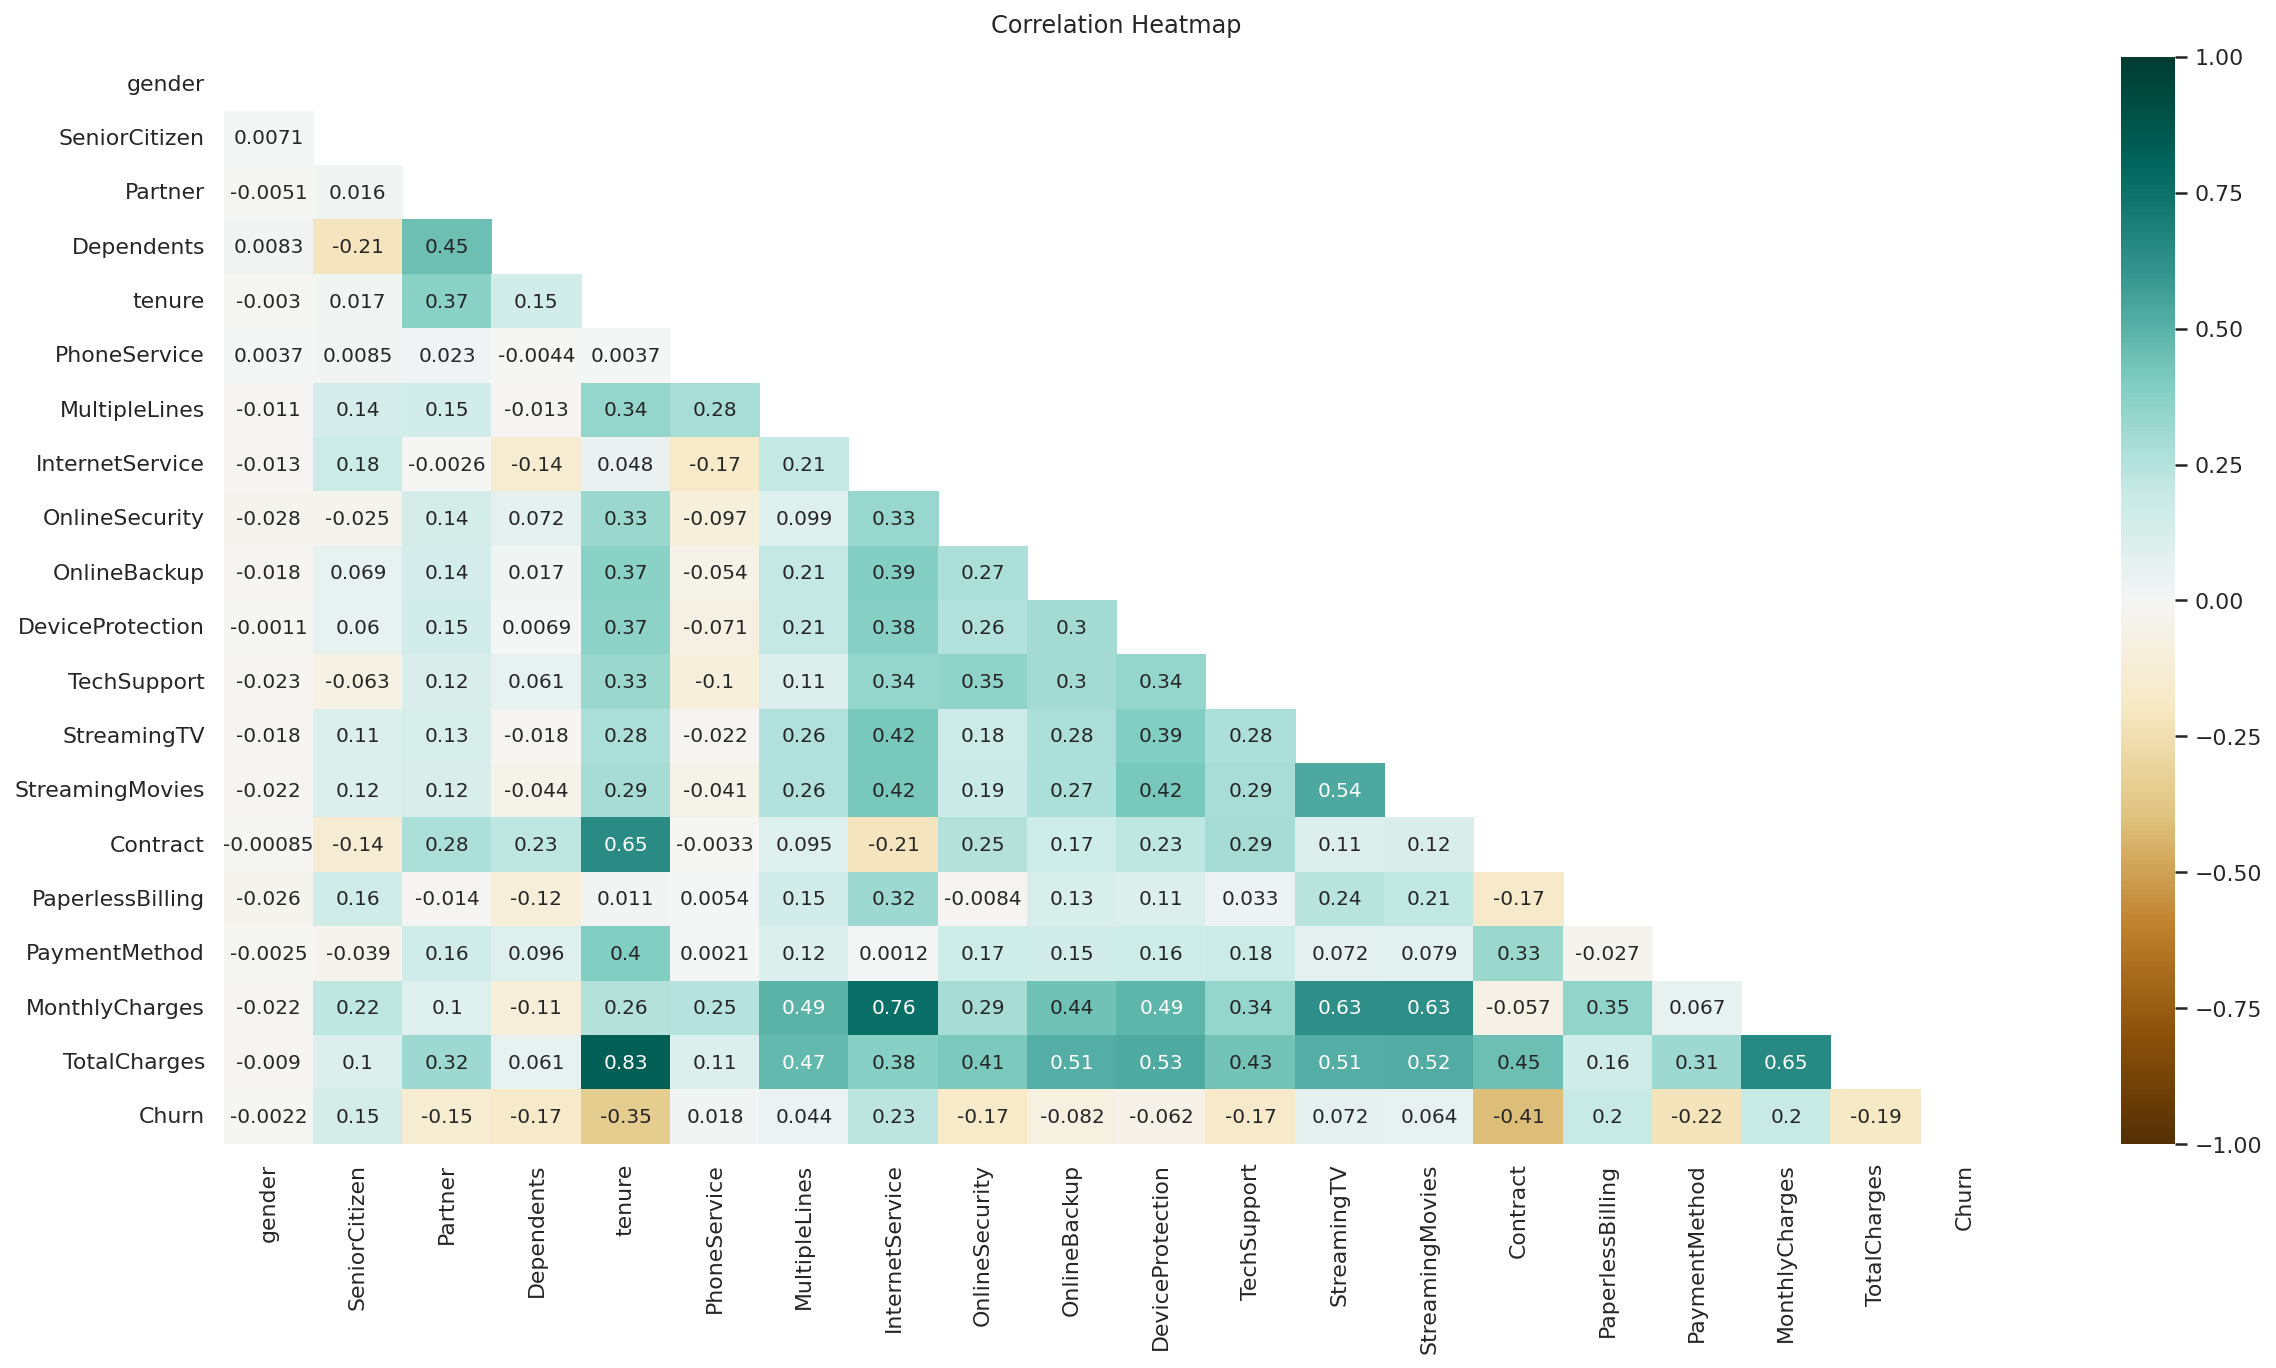

In [45]:
# Increase the size of the heatmap
plt.figure(figsize=(20,10))

# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap
mask = np.triu(np.ones_like(train_data.corr(), dtype=np.bool))
heatmap = sns.heatmap(train_data.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')

# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

## Normalization

In [46]:
# Check train data
train_data

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,1.0,0.0,0.0,0.0,35.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,49.20,1701.65,0
1,1.0,0.0,1.0,1.0,15.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,75.10,1151.55,0
2,1.0,0.0,1.0,1.0,13.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,40.55,590.35,0
3,0.0,0.0,1.0,0.0,26.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,73.50,1905.70,0
4,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,44.55,44.55,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5629,0.0,0.0,1.0,0.0,71.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,109.25,7707.70,0
5630,1.0,0.0,0.0,0.0,2.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,46.05,80.35,1
5631,0.0,1.0,0.0,0.0,25.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,102.80,2660.20,1
5632,0.0,0.0,1.0,0.0,24.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,20.40,482.80,0


In [47]:
# Check descriptive stats for train data
train_data.describe()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
count,5634.000000,5634.000000,5634.000000,5634.000000,5634.000000,5634.000000,5634.000000,5634.000000,5634.000000,5634.000000,5634.000000,5634.000000,5634.000000,5634.000000,5634.000000,5634.000000,5634.000000,5634.000000,5634.000000,5634.000000
mean,0.502840,0.163294,0.484381,0.298012,32.485091,0.900781,0.424210,0.784523,0.288072,0.351083,0.345758,0.292687,0.389421,0.391019,0.449414,0.591232,0.436102,64.929961,2301.319027,0.265353
std,0.500036,0.369667,0.499800,0.457425,24.568744,0.298982,0.494266,0.411190,0.452905,0.477351,0.475657,0.455036,0.487662,0.488022,0.497479,0.491650,0.495944,30.138105,2277.809211,0.441560
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.400000,18.850000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,9.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,35.662500,408.850000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,29.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,70.500000,1397.475000,0.000000
75%,1.000000,0.000000,1.000000,1.000000,55.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,90.000000,3835.825000,1.000000
max,1.000000,1.000000,1.000000,1.000000,72.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,118.750000,8684.800000,1.000000


In [48]:
# Check test data
test_data

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,1.0,0.0,1.0,1.0,72.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,114.05,8468.20,0
1,0.0,1.0,0.0,0.0,8.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,100.15,908.55,0
2,0.0,0.0,1.0,1.0,41.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,78.35,3211.20,0
3,1.0,0.0,1.0,0.0,18.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,78.20,1468.75,0
4,0.0,0.0,1.0,0.0,72.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,82.65,5919.35,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1404,0.0,0.0,1.0,1.0,49.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,87.20,4345.00,0
1405,1.0,0.0,1.0,1.0,28.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,20.30,487.95,0
1406,1.0,0.0,0.0,0.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,20.65,93.55,0
1407,0.0,0.0,0.0,0.0,56.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,19.70,1051.90,0


In [49]:
# Check descriptive stats for test data
test_data.describe()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
count,1409.000000,1409.000000,1409.000000,1409.000000,1409.000000,1409.000000,1409.000000,1409.000000,1409.000000,1409.000000,1409.000000,1409.000000,1409.000000,1409.000000,1409.000000,1409.000000,1409.000000,1409.000000,1409.000000,1409.000000
mean,0.512420,0.157559,0.477644,0.305891,31.915543,0.912704,0.412349,0.778566,0.281050,0.320085,0.336409,0.280341,0.364088,0.375444,0.451384,0.596167,0.432221,64.088857,2204.336072,0.265436
std,0.500023,0.364456,0.499677,0.460947,24.525829,0.282368,0.492432,0.415359,0.449672,0.466675,0.472648,0.449325,0.481344,0.484409,0.497808,0.490839,0.495561,29.898290,2213.518775,0.441722
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.250000,18.800000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,8.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,35.200000,369.250000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,28.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,69.950000,1397.475000,0.000000
75%,1.000000,0.000000,1.000000,1.000000,55.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,89.450000,3517.900000,1.000000
max,1.000000,1.000000,1.000000,1.000000,72.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,116.800000,8496.700000,1.000000


In [50]:
# Reseparate independent and dependent feature of the train-test data
X_train = train_data.drop(['Churn'], axis=1)
y_train = train_data['Churn']

X_test = test_data.drop(['Churn'], axis=1)
y_test = test_data['Churn']

# Data Modeling

## Logistics Regression

In [ ]:
# define logistic regression model
logreg = LogisticRegression(solver='liblinear')
# fit model to data
logreg.fit(X_train, y_train)
# fit prediction model to data
y_pred_logreg = logreg.predict(X_test)

In [ ]:
logreg

LogisticRegression(solver='liblinear')

## K-Nearest Neighbors

In [ ]:
# define k-nearest neighbors classifier
knn = KNeighborsClassifier(n_neighbors = 3)
# fit model to data
knn.fit(X_train, y_train)
# fit prediction model to data
y_pred_knn = knn.predict(X_test)

In [ ]:
knn

KNeighborsClassifier(n_neighbors=3)

## Decision Tree

In [ ]:
# define decision tree classifier
dtree = DecisionTreeClassifier()
# fit model to data
dtree.fit(X_train, y_train)
# fit prediction model to data
y_pred_dtree = dtree.predict(X_test)

In [ ]:
dtree

DecisionTreeClassifier()

## Random Forest

In [ ]:
# define Random Forest classifier
rf = RandomForestClassifier(n_estimators=100)
# fit model to data
rf.fit(X_train, y_train)
# fit prediction model to data
y_pred_rf = rf.predict(X_test)

In [ ]:
rf

RandomForestClassifier()

## XGBoost

In [ ]:
# fit model no training data
xgb = XGBClassifier()
# fit model to data
xgb.fit(X_train, y_train)
# fit prediction model to data
y_pred_xgb = xgb.predict(X_test)

In [ ]:
xgb

XGBClassifier()

## Modeling Comparasion

In [ ]:
models = []
models.append(("Logistic Regression",LogisticRegression(solver='liblinear')))
models.append(("Random Forest",RandomForestClassifier(n_estimators=100)))
models.append(("XGBoost",XGBClassifier()))
models.append(("KNN",KNeighborsClassifier(n_neighbors = 3)))
models.append(("Decision Tree",DecisionTreeClassifier()))

In [ ]:
from sklearn import model_selection
recall_results = []
precision_results = []
auc_results = []
f1_score = []
names = []
col = ['ML Mode','ROC-AUC','ROC-AUC Std','Recall','Recall Std','Precision','Precision Std','F1-Score','F1-Score Std']

df_results = pd.DataFrame(columns=col)

i = 0

c = list(set(X_train.columns))

for name,model in models:
    kfold = model_selection.KFold(n_splits=3)
    cv_recall_results = model_selection.cross_val_score(model,X_train[c],y_train,cv=kfold,scoring="recall")
    
    cv_precision_results = model_selection.cross_val_score(model,X_train[c],y_train,
                                                        cv=kfold,scoring="precision")
    
    cv_auc_results = model_selection.cross_val_score(model,X_train[c],y_train,
                                                   cv=kfold,scoring="roc_auc")
    
    cv_f1_results = model_selection.cross_val_score(model,X_train[c],y_train,
                                                   cv=kfold,scoring="f1")
    recall_results.append(cv_recall_results)
    precision_results.append(cv_precision_results)
    auc_results.append(cv_auc_results)
    f1_score.append(cv_f1_results)
    names.append(name)

    df_results.loc[i] = [name,
                        round(cv_auc_results.mean()*100,2),
                        round(cv_auc_results.std()*100,2),
                        round(cv_recall_results.mean()*100,2),
                        round(cv_recall_results.std()*100,2),
                        round(cv_precision_results.mean()*100,2),
                        round(cv_precision_results.std()*100,2),
                        round(cv_f1_results.mean()*100,2),
                        round(cv_f1_results.std()*100,2)]
    i += 1

In [ ]:
df_results.sort_values('F1-Score',ascending=False)

,ML Mode,ROC-AUC,ROC-AUC Std,Recall,Recall Std,Precision,Precision Std,F1-Score,F1-Score Std
0,Logistic Regression,84.18,1.33,53.79,1.53,65.96,3.28,59.19,1.37
2,XGBoost,84.40,1.56,52.64,2.63,65.79,3.59,58.36,1.55
1,Random Forest,82.30,1.17,48.00,2.25,63.69,3.41,54.31,1.00
3,KNN,71.04,0.77,45.45,0.98,52.61,3.82,48.73,2.11
4,Decision Tree,65.24,0.94,48.33,2.09,48.82,2.06,48.41,2.17


# Model Evaluation

In [ ]:
# Logistics Regression Prediction
lr_pred = logreg.predict(X_test)
lr_pred_proba = logreg.predict_proba(X_test)

# KNN Prediction
knn_pred = knn.predict(X_test)
knn_pred_proba = knn.predict_proba(X_test)

# Decision Tree Prediction
dtree_pred = dtree.predict(X_test)
dtree_pred_proba = dtree.predict_proba(X_test)

# Random Forest Prediction
rf_pred = rf.predict(X_test)
rf_pred_proba = rf.predict_proba(X_test)

# XGBoost Prediction
xgb_pred = xgb.predict(X_test)
xgb_pred_proba = xgb.predict_proba(X_test)

### Classification Report

In [ ]:
# Logistics Regression Prediction Result
pd.DataFrame(metrics.classification_report(y_test, lr_pred, target_names=['0','1'], output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.845173,0.655949,0.803407,0.750561,0.794946
recall,0.896618,0.545455,0.803407,0.721036,0.803407
f1-score,0.870136,0.595620,0.803407,0.732878,0.797270
support,1035.000000,374.000000,0.803407,1409.000000,1409.000000


In [ ]:
# KNN prediction result
pd.DataFrame(metrics.classification_report(y_test, knn_pred, target_names=['0','1'], output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.815385,0.559211,0.760114,0.687298,0.747387
recall,0.870531,0.454545,0.760114,0.662538,0.760114
f1-score,0.842056,0.501475,0.760114,0.671766,0.751653
support,1035.000000,374.000000,0.760114,1409.000000,1409.000000


In [ ]:
# Decision Tree prediction result
pd.DataFrame(metrics.classification_report(y_test, dtree_pred, target_names=['0','1'], output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.815816,0.463415,0.713272,0.639615,0.722276
recall,0.787440,0.508021,0.713272,0.647731,0.713272
f1-score,0.801377,0.484694,0.713272,0.643035,0.717317
support,1035.000000,374.000000,0.713272,1409.000000,1409.000000


In [ ]:
# random forest prediction result
pd.DataFrame(metrics.classification_report(y_test, rf_pred, target_names=['0','1'], output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.820195,0.610714,0.778566,0.715455,0.764591
recall,0.894686,0.457219,0.778566,0.675953,0.778566
f1-score,0.855823,0.522936,0.778566,0.689379,0.767462
support,1035.000000,374.000000,0.778566,1409.000000,1409.000000


In [ ]:
# XGBoost prediction result
pd.DataFrame(metrics.classification_report(y_test, xgb_pred, target_names=['0','1'], output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.839029,0.656566,0.800568,0.747797,0.790596
recall,0.901449,0.521390,0.800568,0.711420,0.800568
f1-score,0.869120,0.581222,0.800568,0.725171,0.792701
support,1035.000000,374.000000,0.800568,1409.000000,1409.000000


### Confusion Matrix

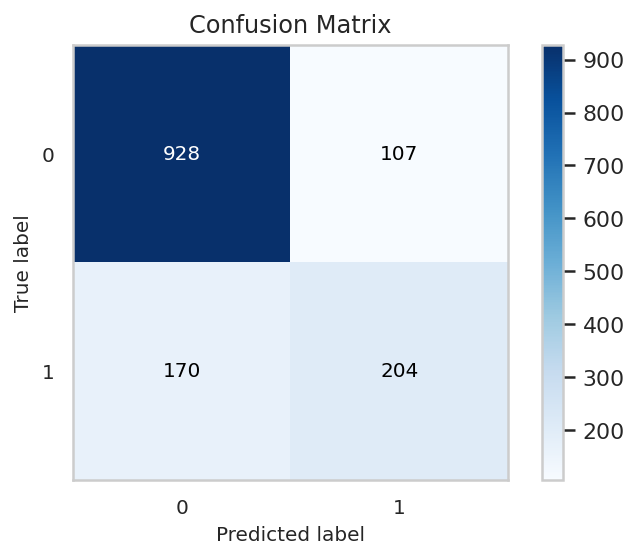

In [ ]:
# Logistic Regression result
skplt.metrics.plot_confusion_matrix(y_test, lr_pred);

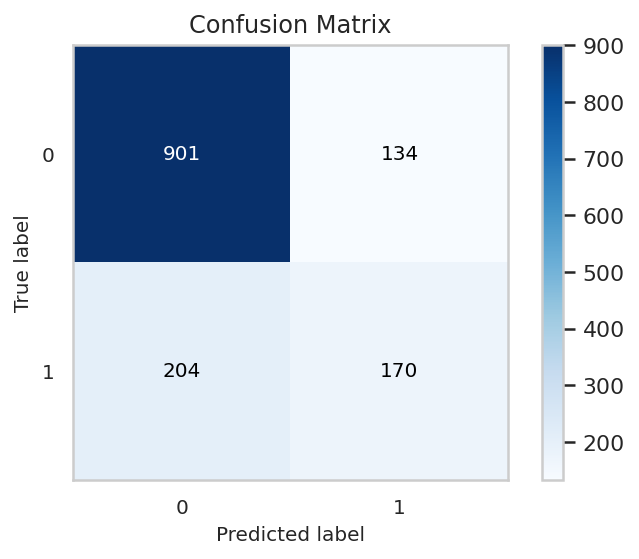

In [ ]:
# KNN result
skplt.metrics.plot_confusion_matrix(y_test, knn_pred);

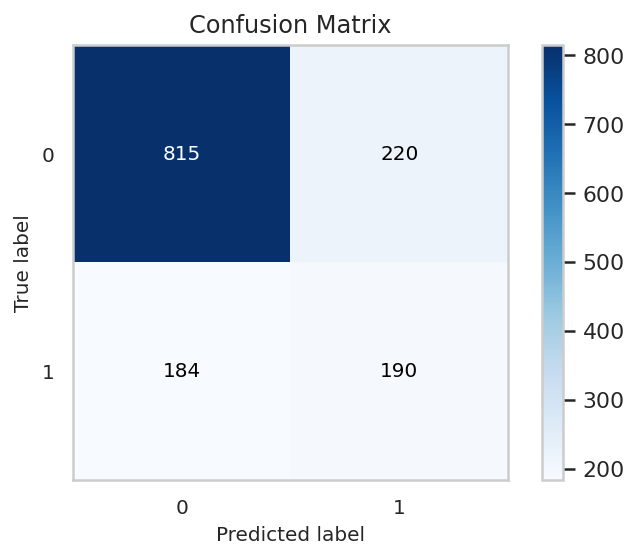

In [ ]:
# Decision Tree result
skplt.metrics.plot_confusion_matrix(y_test, dtree_pred);

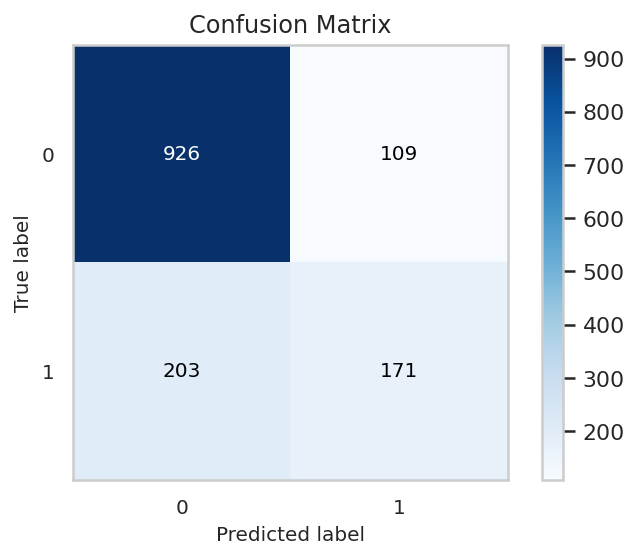

In [ ]:
# random forest result
skplt.metrics.plot_confusion_matrix(y_test, rf_pred);

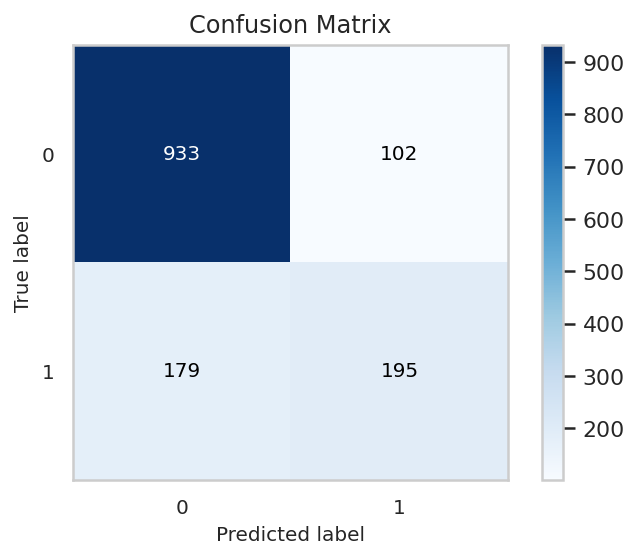

In [ ]:
# xgboost result
skplt.metrics.plot_confusion_matrix(y_test, xgb_pred);

### ROC-AUC

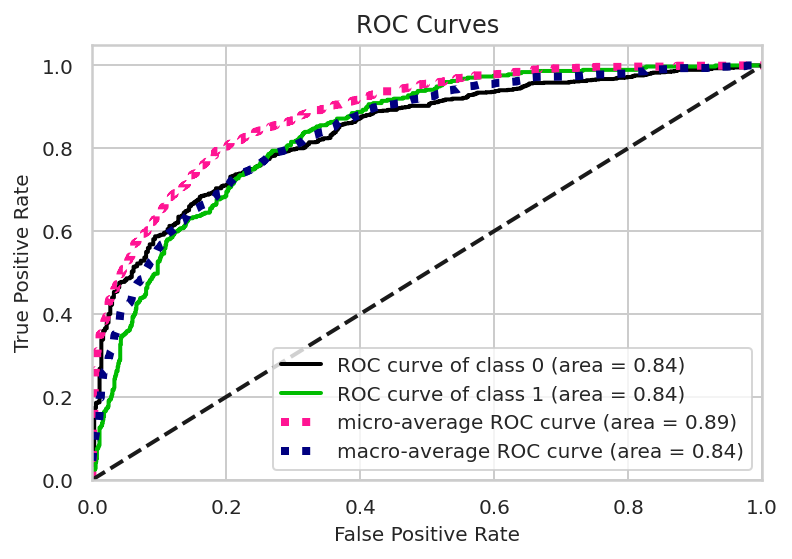

In [ ]:
# Log result
skplt.metrics.plot_roc_curve(y_test, lr_pred_proba);

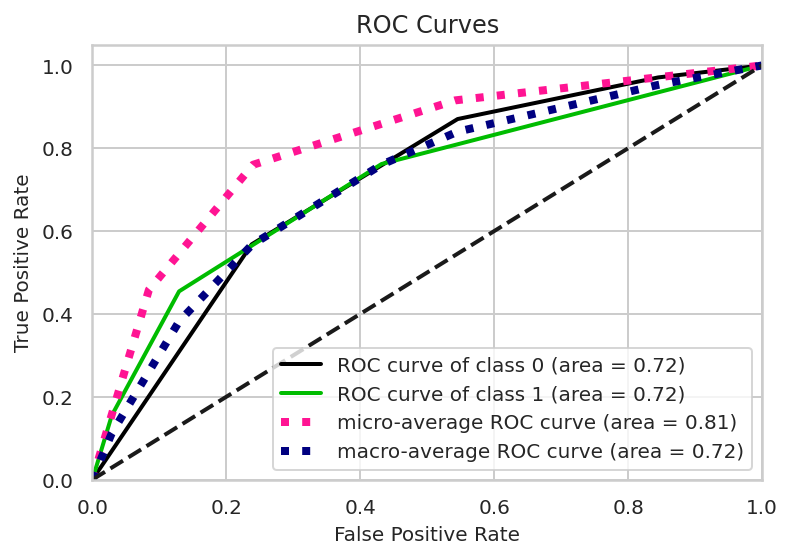

In [ ]:
# KNN result
skplt.metrics.plot_roc_curve(y_test, knn_pred_proba);

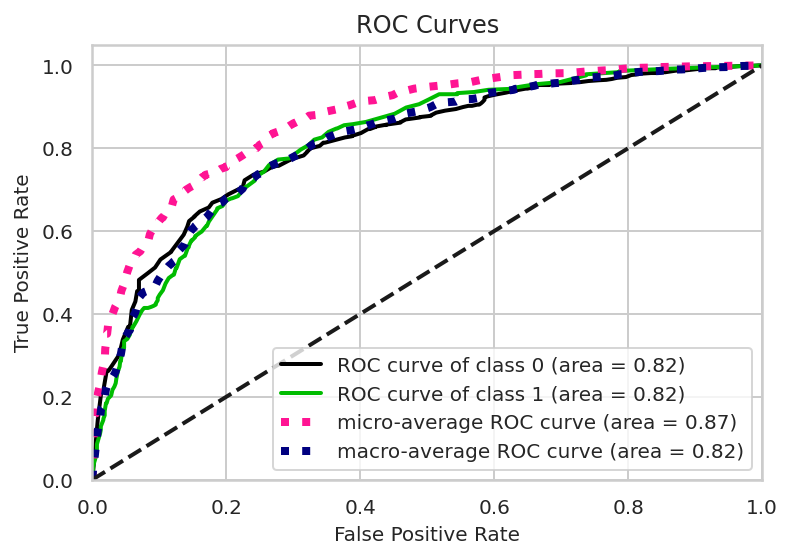

In [ ]:
# random forest result
skplt.metrics.plot_roc_curve(y_test, rf_pred_proba);

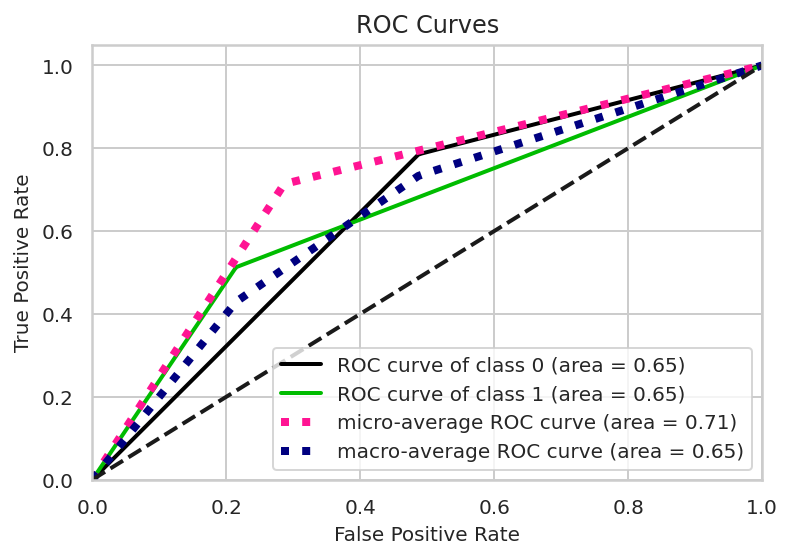

In [ ]:
# Decision Tree perceptron result
skplt.metrics.plot_roc_curve(y_test, dtree_pred_proba);

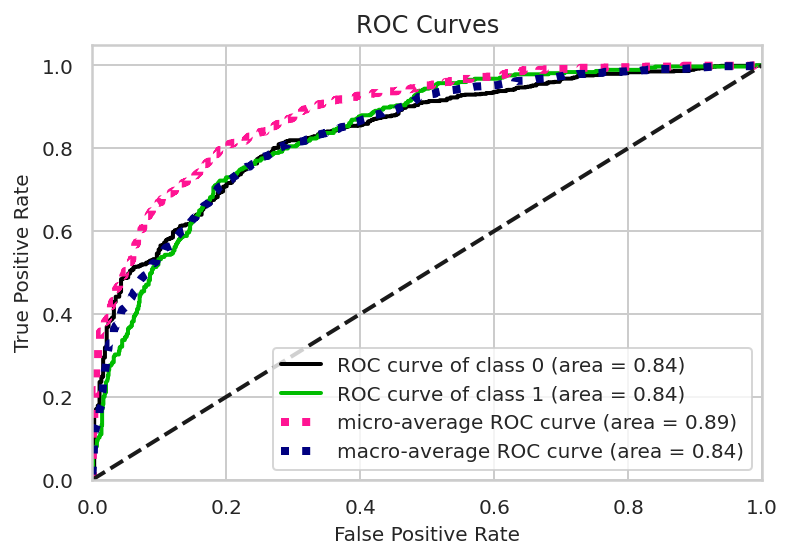

In [ ]:
# XGBoost perceptron result
skplt.metrics.plot_roc_curve(y_test, xgb_pred_proba);

### AOC Score

In [ ]:
# check LogReg f1-score
metrics.roc_auc_score(y_test, lr_pred)

0.7210364514712341

In [ ]:
# check KNN f1-score
metrics.roc_auc_score(y_test, knn_pred)

0.6625384277558191

In [ ]:
# check Decision Tree f1-score
metrics.roc_auc_score(y_test, dtree_pred)

0.6477305019504508

In [ ]:
# check Random Forest f1-score
metrics.roc_auc_score(y_test, rf_pred)

0.6759526208375314

In [ ]:
# check XGBoost f1-score
metrics.roc_auc_score(y_test, xgb_pred)

0.7114198248469349

### Precision

In [ ]:
# check LogReg f1-score
metrics.precision_score(y_test, lr_pred)

0.6559485530546624

In [ ]:
# check KNN f1-score
metrics.precision_score(y_test, knn_pred)

0.5592105263157895

In [ ]:
# check Decision Tree f1-score
metrics.precision_score(y_test, dtree_pred)

0.4634146341463415

In [ ]:
# check Random Forest f1-score
metrics.precision_score(y_test, rf_pred)

0.6107142857142858

In [ ]:
# check XGBoost f1-score
metrics.precision_score(y_test, xgb_pred)

0.6565656565656566

### Recall

In [ ]:
# check LogReg f1-score
metrics.recall_score(y_test, lr_pred)

0.5454545454545454

In [ ]:
# check KNN f1-score
metrics.recall_score(y_test, knn_pred)

0.45454545454545453

In [ ]:
# check Decision Tree f1-score
metrics.recall_score(y_test, dtree_pred)

0.5080213903743316

In [ ]:
# check Random Forest f1-score
metrics.recall_score(y_test, rf_pred)

0.4572192513368984

In [ ]:
# check XGBoost f1-score
metrics.recall_score(y_test, xgb_pred)

0.5213903743315508

### F1-Score

In [ ]:
# check LogReg f1-score
metrics.f1_score(y_test, lr_pred)

0.5956204379562043

In [ ]:
# check KNN f1-score
metrics.f1_score(y_test, knn_pred)

0.5014749262536874

In [ ]:
# check Decision Tree f1-score
metrics.f1_score(y_test, dtree_pred)

0.48469387755102045

In [ ]:
# check Random Forest f1-score
metrics.f1_score(y_test, rf_pred)

0.5229357798165137

In [ ]:
# check XGBoost f1-score
metrics.f1_score(y_test, xgb_pred)

0.5812220566318926

# Imbalanced Modelling using G-Means

## Logistic Regression

In [ ]:
# find fpr and tpr using roc_curve() method
fpr, tpr, thresholds = metrics.roc_curve(y_test, lr_pred_proba[:,1])

# calculate g-means
gmeans = np.sqrt(tpr * (1-fpr))

# find the best threshold
ix = np.argmax(gmeans)

print('Best Threshold={}, G-Mean={}'.format(thresholds[ix], gmeans[ix]))

Best Threshold=0.27458483803332684, G-Mean=0.7621144365003529


### New Prediction

In [ ]:
# change predict proba result to optimized one using new threshold
new_pred_result = (lr_pred_proba[:,1] >= thresholds[ix]).astype(int)

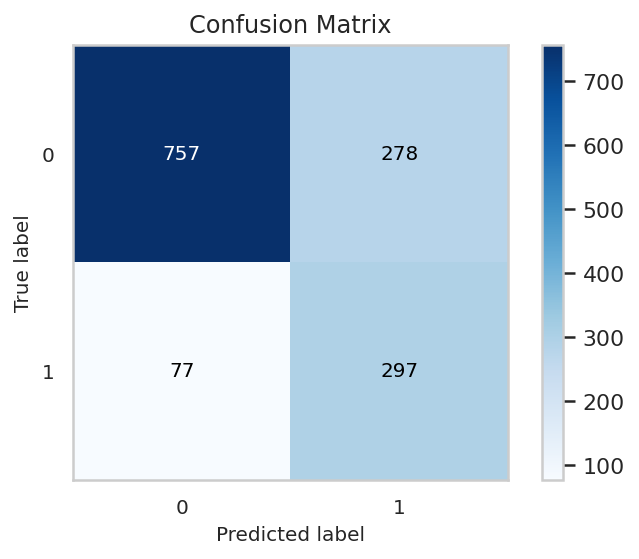

In [ ]:
# visualize confusion matrix after setting new threshold
skplt.metrics.plot_confusion_matrix(y_test, new_pred_result);

In [ ]:
# check new ROC-AUC
metrics.roc_auc_score(y_test, new_pred_result)

0.7627593066211991

In [ ]:
# check new precision
metrics.precision_score(y_test, new_pred_result)

0.5165217391304348

In [ ]:
# check new recall
metrics.recall_score(y_test, new_pred_result)

0.7941176470588235

In [ ]:
# check new f1-score
metrics.f1_score(y_test, new_pred_result)

0.6259220231822972

In [ ]:
# check classification report result of new prediction result
pd.DataFrame(metrics.classification_report(y_test, new_pred_result, target_names=['0','1'], output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.907674,0.516522,0.748048,0.712098,0.803848
recall,0.731401,0.794118,0.748048,0.762759,0.748048
f1-score,0.810059,0.625922,0.748048,0.717990,0.761182
support,1035.000000,374.000000,0.748048,1409.000000,1409.000000


### Old Prediction

In [ ]:
# check old ROC-AUC
metrics.roc_auc_score(y_test, lr_pred)

0.7210364514712341

In [ ]:
# check old precision
metrics.precision_score(y_test, lr_pred)

0.6559485530546624

In [ ]:
# check old recall
metrics.recall_score(y_test, lr_pred)

0.5454545454545454

In [ ]:
# compare to the old f1 score
metrics.f1_score(y_test, lr_pred)

0.5956204379562043

In [ ]:
# check classification report result of previous prediction result
pd.DataFrame(metrics.classification_report(y_test, lr_pred, target_names=['0','1'], output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.845173,0.655949,0.803407,0.750561,0.794946
recall,0.896618,0.545455,0.803407,0.721036,0.803407
f1-score,0.870136,0.595620,0.803407,0.732878,0.797270
support,1035.000000,374.000000,0.803407,1409.000000,1409.000000


## K-Nearest Neighbors

In [ ]:
# find fpr and tpr using roc_curve() method
fpr, tpr, thresholds = metrics.roc_curve(y_test, knn_pred_proba[:,1])

# calculate g-means
gmeans = np.sqrt(tpr * (1-fpr))

# find the best threshold
ix = np.argmax(gmeans)

print('Best Threshold={}, G-Mean={}'.format(thresholds[ix], gmeans[ix]))

Best Threshold=0.3333333333333333, G-Mean=0.6579685221536685


### New Prediction

In [ ]:
# change predict proba result to optimized one using new threshold
new_pred_result = (knn_pred_proba[:,1] >= thresholds[ix]).astype(int)

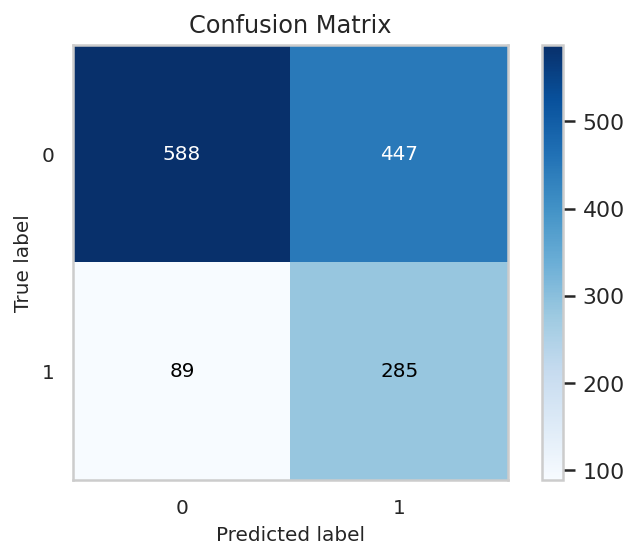

In [ ]:
# visualize confusion matrix after setting new threshold
skplt.metrics.plot_confusion_matrix(y_test, new_pred_result);

In [ ]:
# check new ROC-AUC
metrics.roc_auc_score(y_test, new_pred_result)

0.6650740137952416

In [ ]:
# check new precision
metrics.precision_score(y_test, new_pred_result)

0.38934426229508196

In [ ]:
# check new recall
metrics.recall_score(y_test, new_pred_result)

0.7620320855614974

In [ ]:
# check new f1-score
metrics.f1_score(y_test, new_pred_result)

0.515370705244123

In [ ]:
# check classification report result of new prediction result
pd.DataFrame(metrics.classification_report(y_test, new_pred_result, target_names=['0','1'], output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.868538,0.389344,0.619588,0.628941,0.741342
recall,0.568116,0.762032,0.619588,0.665074,0.619588
f1-score,0.686916,0.515371,0.619588,0.601143,0.641382
support,1035.000000,374.000000,0.619588,1409.000000,1409.000000


### Old Prediction

In [ ]:
# check old ROC-AUC
metrics.roc_auc_score(y_test, lr_pred)

0.7210364514712341

In [ ]:
# check old precision
metrics.precision_score(y_test, knn_pred)

0.5592105263157895

In [ ]:
# check old recall
metrics.recall_score(y_test, knn_pred)

0.45454545454545453

In [ ]:
# compare to the old f1 score
metrics.f1_score(y_test, knn_pred)

0.5014749262536874

In [ ]:
# check classification report result of previous prediction result
pd.DataFrame(metrics.classification_report(y_test, knn_pred, target_names=['0','1'], output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.815385,0.559211,0.760114,0.687298,0.747387
recall,0.870531,0.454545,0.760114,0.662538,0.760114
f1-score,0.842056,0.501475,0.760114,0.671766,0.751653
support,1035.000000,374.000000,0.760114,1409.000000,1409.000000


## Decision Tree

In [ ]:
# find fpr and tpr using roc_curve() method
fpr, tpr, thresholds = metrics.roc_curve(y_test, dtree_pred_proba[:,1])

# calculate g-means
gmeans = np.sqrt(tpr * (1-fpr))

# find the best threshold
ix = np.argmax(gmeans)

print('Best Threshold={}, G-Mean={}'.format(thresholds[ix], gmeans[ix]))

Best Threshold=0.5, G-Mean=0.6346330028318296


In [ ]:
# change predict proba result to optimized one using new threshold
new_pred_result = (dtree_pred_proba[:,1] >= thresholds[ix]).astype(int)

### New Prediction

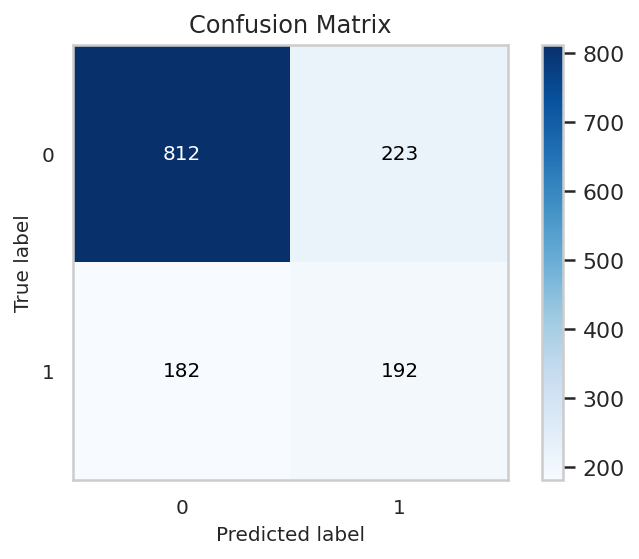

In [ ]:
# visualize confusion matrix after setting new threshold
skplt.metrics.plot_confusion_matrix(y_test, new_pred_result);

In [ ]:
# check new ROC-AUC
metrics.roc_auc_score(y_test, new_pred_result)

0.6489550233795759

In [ ]:
# check new precision
metrics.precision_score(y_test, new_pred_result)

0.46265060240963857

In [ ]:
# check new recall
metrics.recall_score(y_test, new_pred_result)

0.5133689839572193

In [ ]:
# check new f1-score
metrics.f1_score(y_test, new_pred_result)

0.48669201520912553

In [ ]:
# check classification report result of new prediction result
pd.DataFrame(metrics.classification_report(y_test, new_pred_result, target_names=['0','1'], output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.816901,0.462651,0.712562,0.639776,0.722870
recall,0.784541,0.513369,0.712562,0.648955,0.712562
f1-score,0.800394,0.486692,0.712562,0.643543,0.717126
support,1035.000000,374.000000,0.712562,1409.000000,1409.000000


### Old Prediction

In [ ]:
# check old f1-score
metrics.roc_auc_score(y_test, dtree_pred)

0.6477305019504508

In [ ]:
# check old precision
metrics.precision_score(y_test, dtree_pred)

0.4634146341463415

In [ ]:
# check old recall
metrics.recall_score(y_test, dtree_pred)

0.5080213903743316

In [ ]:
# compare to the old f1 score
metrics.f1_score(y_test, dtree_pred)

0.48469387755102045

In [ ]:
# check classification report result of previous prediction result
pd.DataFrame(metrics.classification_report(y_test, dtree_pred, target_names=['0','1'], output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.815816,0.463415,0.713272,0.639615,0.722276
recall,0.787440,0.508021,0.713272,0.647731,0.713272
f1-score,0.801377,0.484694,0.713272,0.643035,0.717317
support,1035.000000,374.000000,0.713272,1409.000000,1409.000000


## Random Forest

In [ ]:
# find fpr and tpr using roc_curve() method
fpr, tpr, thresholds = metrics.roc_curve(y_test, rf_pred_proba[:,1])

# calculate g-means
gmeans = np.sqrt(tpr * (1-fpr))

# find the best threshold
ix = np.argmax(gmeans)

print('Best Threshold={}, G-Mean={}'.format(thresholds[ix], gmeans[ix]))

Best Threshold=0.28, G-Mean=0.747705679807378


In [ ]:
# change predict proba result to optimized one using new threshold
new_pred_result = (rf_pred_proba[:,1] >= thresholds[ix]).astype(int)

### New Prediction

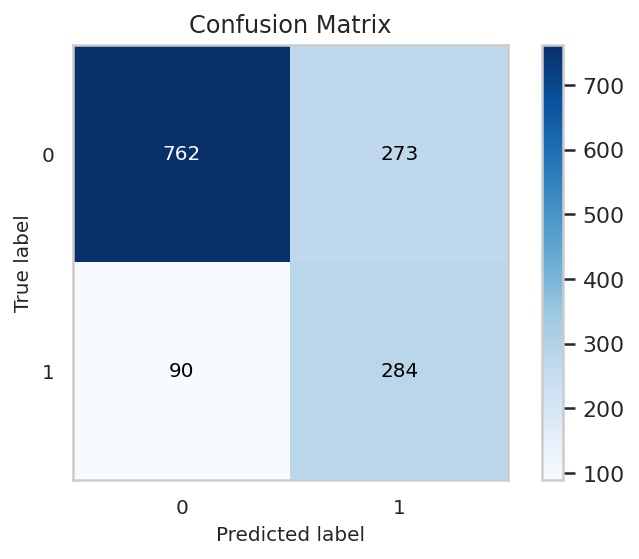

In [ ]:
# visualize confusion matrix after setting new threshold
skplt.metrics.plot_confusion_matrix(y_test, new_pred_result);

In [ ]:
# check new ROC-AUC
metrics.roc_auc_score(y_test, new_pred_result)

0.7477950864140123

In [ ]:
# check new precision
metrics.precision_score(y_test, new_pred_result)

0.5098743267504489

In [ ]:
# check new recall
metrics.recall_score(y_test, new_pred_result)

0.7593582887700535

In [ ]:
# check new f1-score
metrics.f1_score(y_test, new_pred_result)

0.6100966702470463

In [ ]:
# check classification report result of new prediction result
pd.DataFrame(metrics.classification_report(y_test, new_pred_result, target_names=['0','1'], output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.894366,0.509874,0.74237,0.702120,0.792308
recall,0.736232,0.759358,0.74237,0.747795,0.742370
f1-score,0.807631,0.610097,0.74237,0.708864,0.755198
support,1035.000000,374.000000,0.74237,1409.000000,1409.000000


### Old Prediction

In [ ]:
# check old ROC-AUC
metrics.roc_auc_score(y_test, rf_pred)

0.6759526208375314

In [ ]:
# check old precision
metrics.precision_score(y_test, rf_pred)

0.6107142857142858

In [ ]:
# check old recall
metrics.recall_score(y_test, rf_pred)

0.4572192513368984

In [ ]:
# compare to the old f1 score
metrics.f1_score(y_test, rf_pred)

0.5229357798165137

In [ ]:
# check classification report result of previous prediction result
pd.DataFrame(metrics.classification_report(y_test, rf_pred, target_names=['0','1'], output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.820195,0.610714,0.778566,0.715455,0.764591
recall,0.894686,0.457219,0.778566,0.675953,0.778566
f1-score,0.855823,0.522936,0.778566,0.689379,0.767462
support,1035.000000,374.000000,0.778566,1409.000000,1409.000000


## XGBoost

In [ ]:
# find fpr and tpr using roc_curve() method
fpr, tpr, thresholds = metrics.roc_curve(y_test, xgb_pred_proba[:,1])

# calculate g-means
gmeans = np.sqrt(tpr * (1-fpr))

# find the best threshold
ix = np.argmax(gmeans)

print('Best Threshold={}, G-Mean={}'.format(thresholds[ix], gmeans[ix]))

Best Threshold=0.3645085394382477, G-Mean=0.7645359566537782


In [ ]:
# change predict proba result to optimized one using new threshold
new_pred_result = (xgb_pred_proba[:,1] >= thresholds[ix]).astype(int)

### New Prediction

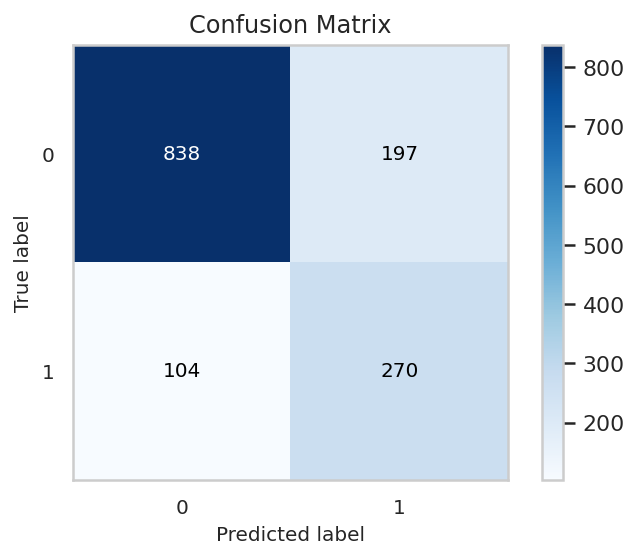

In [ ]:
# visualize confusion matrix after setting new threshold
skplt.metrics.plot_confusion_matrix(y_test, new_pred_result);

In [ ]:
# check new ROC-AUC
metrics.roc_auc_score(y_test, new_pred_result)

0.7657934847193159

In [ ]:
# check new precision
metrics.precision_score(y_test, new_pred_result)

0.5781584582441114

In [ ]:
# check new recall
metrics.recall_score(y_test, new_pred_result)

0.7219251336898396

In [ ]:
# check new f1-score
metrics.f1_score(y_test, new_pred_result)

0.6420927467300832

In [ ]:
# check classification report result of new prediction result
pd.DataFrame(metrics.classification_report(y_test, new_pred_result, target_names=['0','1'], output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.889597,0.578158,0.786373,0.733878,0.806930
recall,0.809662,0.721925,0.786373,0.765793,0.786373
f1-score,0.847749,0.642093,0.786373,0.744921,0.793160
support,1035.000000,374.000000,0.786373,1409.000000,1409.000000


### Old Prediction

In [ ]:
# check old ROC-AUC
metrics.roc_auc_score(y_test, xgb_pred)

0.7114198248469349

In [ ]:
# check old precision
metrics.precision_score(y_test, xgb_pred)

0.6565656565656566

In [ ]:
# check old recall
metrics.recall_score(y_test, xgb_pred)

0.5213903743315508

In [ ]:
# compare to the old f1 score
metrics.f1_score(y_test, xgb_pred)

0.5812220566318926

In [ ]:
# check classification report result of previous prediction result
pd.DataFrame(metrics.classification_report(y_test, xgb_pred, target_names=['0','1'], output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.839029,0.656566,0.800568,0.747797,0.790596
recall,0.901449,0.521390,0.800568,0.711420,0.800568
f1-score,0.869120,0.581222,0.800568,0.725171,0.792701
support,1035.000000,374.000000,0.800568,1409.000000,1409.000000


# Model Interpretation

### Variable Importance - Partial Dependence Plot

In [ ]:
## initiate explainer for LogReg model
churn_exp = dx.Explainer(logreg, X_train, y_train, label = "Logistics Regression Interpretation")

Preparation of a new explainer is initiated

  -> data              : 5634 rows 19 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 5634 values
  -> model_class       : sklearn.linear_model._logistic.LogisticRegression (default)
  -> label             : Logistics Regression Interpretation
  -> predict function  : <function yhat_proba_default at 0x7ff706076a70> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.00204, mean = 0.268, max = 0.865
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.851, mean = -0.00261, max = 0.995
  -> model_info        : package sklearn

A new explainer has been created!


In [ ]:
# visualize permutation feature importance for XGBoost model
churn_exp.model_parts().plot()

In [ ]:
# create partial dependence plot of XGBoost model
churn_exp.model_profile().plot()

Calculating ceteris paribus: 100%|██████████| 19/19 [00:00<00:00, 82.66it/s]


# Business Evaluation Metrics

### Gain Cumulative Curve

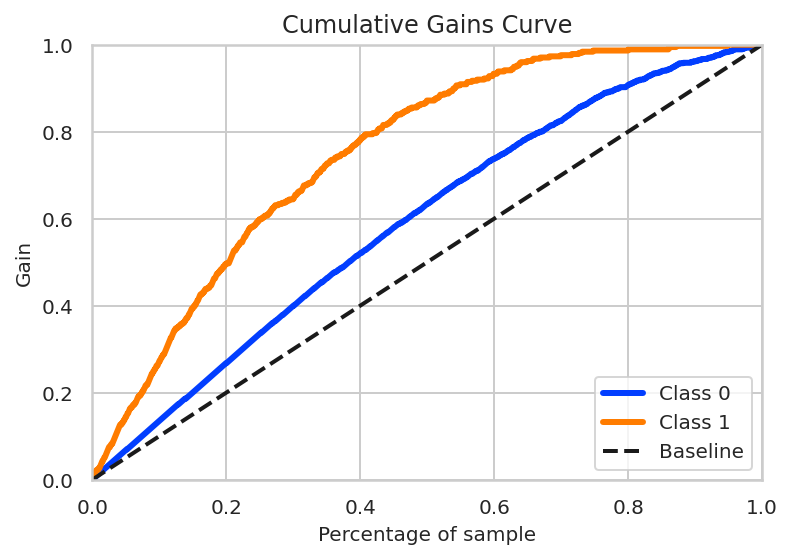

In [ ]:
skplt.metrics.plot_cumulative_gain(y_test, lr_pred_proba)

### Lift Curve

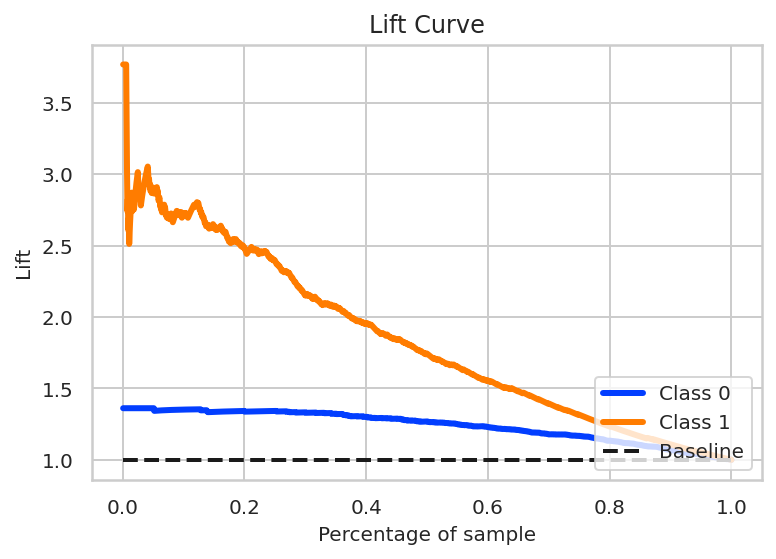

In [ ]:
skplt.metrics.plot_lift_curve(y_test, lr_pred_proba)

### Profit Curve

In [ ]:
def standard_confusion_matrix(y_true, y_pred):
    '''
    Reformat confusion matrix output from sklearn for plotting profit curve.
    '''
    [[tn, fp], [fn, tp]] = metrics.confusion_matrix(y_true, y_pred)
    return np.array([[tp, fp], [fn, tn]])

def plot_profit_curve(model_object, costbenefit_mat, y_proba, y_test):
    '''
    Plot profit curve.

    INPUTS:
    - model object
    - cost benefit matrix in the same format as the confusion matrix above
    - predicted probabilities
    - actual labels
    '''

    # Profit curve data
    profits = [] # one profit value for each T (threshold)
    thresholds = sorted(y_proba, reverse=True)

    # For each threshold, calculate profit - starting with largest threshold
    for T in thresholds:
        y_pred = (y_proba > T).astype(int)
        confusion_mat = metrics.confusion_matrix(y_test, y_pred)
        # Calculate total profit for this threshold
        profit = sum(sum(confusion_mat * costbenefit_mat)) / len(y_test)
        profits.append(profit)

    print(profits)
    # Profit curve plot
    model_name = model_object.__class__.__name__
    max_profit = max(profits)
    plt.plot(np.linspace(0, 1, len(y_test)), profits, label = '{}, max profit ${:.2f} per user'.format(model_name, max_profit))


In [ ]:
# create cost benefit matrix
costbenefit_mat = np.array([[0, -10000],
                            [0, 30000 - 10000]])

In [ ]:
# check cost benefit matrix
costbenefit_mat

array([[     0, -10000],
       [     0,  20000]])

In [ ]:
# check model confusion matrix
metrics.confusion_matrix(y_test, lr_pred)

array([[928, 107],
       [170, 204]])

In [ ]:
# Logistic Regression
logreg = LogisticRegression(random_state=42)

# Logreg params
logreg_params = {
    'penalty': ['elasticnet', 'l2'],
    'fit_intercept': [True, False],
    'C': [0.25, 0.5, 0.75, 1.0]
}

# define model with GridSearchCV
grid_search = GridSearchCV(
    estimator=logreg, 
    param_grid=logreg_params, 
    n_jobs=1, 
    verbose=1,
    cv = 5,
    scoring = "f1"
)

# fitting gridsearch
grid_search.fit(X_train, y_train)

# check the best estimator
grid_search.best_estimator_

Fitting 5 folds for each of 16 candidates, totalling 80 fits


LogisticRegression(C=0.5, fit_intercept=False, random_state=42)

In [ ]:
# assign the best estimator to new variable
tree_best = grid_search.best_estimator_

[0.0, 14.194464158977999, 28.388928317955997, 42.583392476933994, 56.777856635911995, 70.97232079489, 85.16678495386799, 99.361249112846, 113.55571327182399, 106.45848119233499, 99.361249112846, 92.26401703335699, 106.45848119233499, 99.361249112846, 113.55571327182399, 106.45848119233499, 120.652945351313, 134.847409510291, 149.041873669269, 163.23633782824697, 177.43080198722498, 191.625266146203, 184.52803406671399, 198.722498225692, 212.91696238466997, 227.11142654364798, 220.01419446415898, 234.20865862313698, 248.40312278211496, 262.59758694109297, 276.792051100071, 290.986515259049, 305.180979418027, 319.37544357700494, 333.56990773598295, 347.76437189496096, 340.66713981547196, 333.56990773598295, 347.76437189496096, 361.95883605393897, 354.86160397444996, 369.05606813342797, 361.95883605393897, 376.153300212917, 390.347764371895, 404.54222853087293, 418.73669268985094, 432.93115684882895, 447.12562100780696, 461.32008516678496, 475.51454932576297, 489.709013484741, 503.9034776

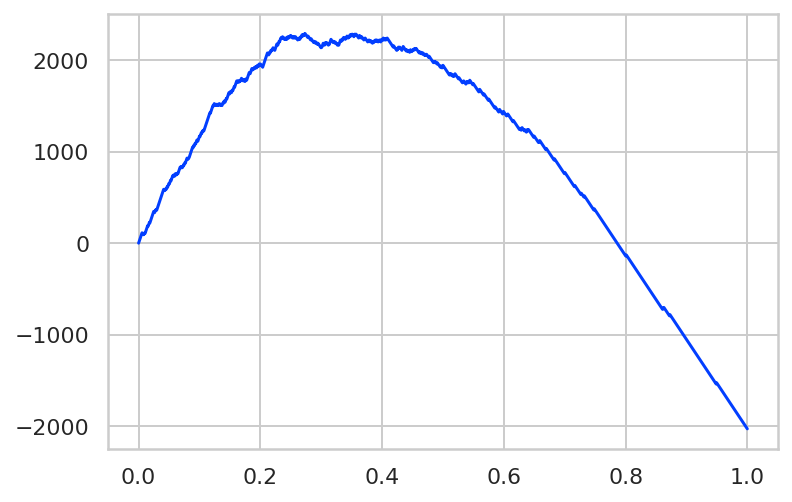

In [ ]:
plot_profit_curve(tree_best,costbenefit_mat, lr_pred_proba[:,1], y_test)

[0.0, 14.194464158977999, 28.388928317955997, 42.583392476933994, 56.777856635911995, 70.97232079489, 85.16678495386799, 99.361249112846, 113.55571327182399, 106.45848119233499, 99.361249112846, 92.26401703335699, 106.45848119233499, 99.361249112846, 113.55571327182399, 106.45848119233499, 120.652945351313, 134.847409510291, 149.041873669269, 163.23633782824697, 177.43080198722498, 191.625266146203, 184.52803406671399, 198.722498225692, 212.91696238466997, 227.11142654364798, 220.01419446415898, 234.20865862313698, 248.40312278211496, 262.59758694109297, 276.792051100071, 290.986515259049, 305.180979418027, 319.37544357700494, 333.56990773598295, 347.76437189496096, 340.66713981547196, 333.56990773598295, 347.76437189496096, 361.95883605393897, 354.86160397444996, 369.05606813342797, 361.95883605393897, 376.153300212917, 390.347764371895, 404.54222853087293, 418.73669268985094, 432.93115684882895, 447.12562100780696, 461.32008516678496, 475.51454932576297, 489.709013484741, 503.9034776

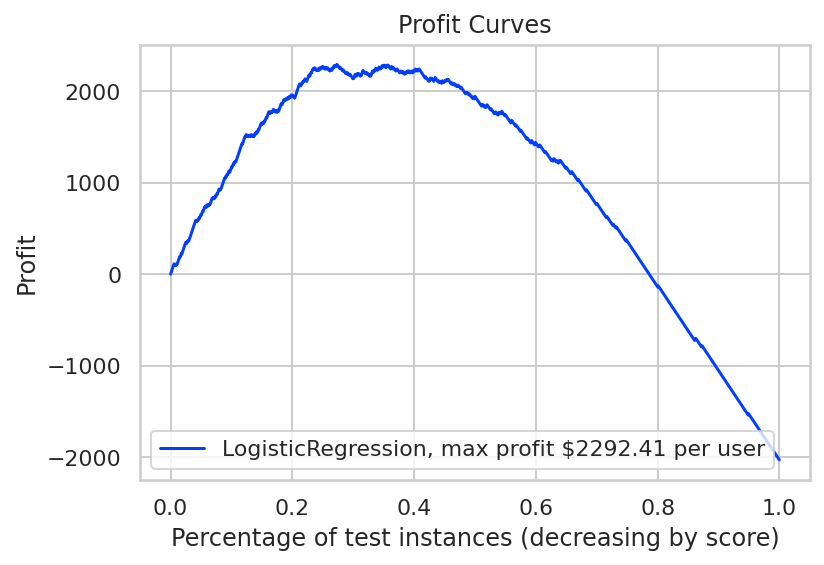

In [ ]:
plot_profit_curve(tree_best,costbenefit_mat, lr_pred_proba[:,1], y_test)
plt.xlabel('Percentage of test instances (decreasing by score)')
plt.ylabel('Profit')
plt.title('Profit Curves')
plt.legend(loc='lower left')
plt.show()